# Detección de Hernia Hiatal en RX Frontal

Este notebook está escrito para que sea fácil de seguir.

Idea principal:
- Le mostramos radiografías al modelo.
- El modelo aprende a decir si la imagen parece `normal` o `hernia`.
- Medimos qué tan bien lo hace.
- Guardamos resultados para revisarlos después.

Ruta rápida del notebook (enlaces):
1. [Etapa 1: Configuración clara y mínima](#etapa-1)
2. [Etapa 2: Utilidades del pipeline (simples y comentadas)](#etapa-2)
3. [Etapa 3: Cargar datos y ver cuántos hay por clase](#etapa-3)
4. [Etapa 4: Inspección visual rápida](#etapa-4)
5. [Etapa 5: Split y DataLoaders](#etapa-5)
6. [Etapa 6: Preparar modelo, pérdida y optimizador](#etapa-6)
7. [Etapa 7: Entrenamiento del fold demo](#etapa-7)
8. [Etapa 8: Curvas de entrenamiento](#etapa-8)
9. [Etapa 9: Evaluación del fold demo + guardado de predicciones](#etapa-9)
10. [Etapa 10: Interpretabilidad con Grad-CAM (ejemplos TP/TN/FP/FN)](#etapa-10)
11. [Etapa 11: Validación cruzada completa (opcional)](#etapa-11)
12. [Etapa 12: Lectura clínica rápida (explicación humana)](#etapa-12)
13. [Etapa 13: Resumen final: train vs validación](#etapa-13)
15. [Etapa 15: Inferencia en 5 imágenes aleatorias (balanceadas)](#etapa-15)

<a id="etapa-1"></a>
## Etapa 1: Configuración clara y mínima

In [ ]:
%pip install torch
%pip install torchvision
%pip install numpy
%pip install pandas
%pip install matplontlib
%pip install scikit-learn
%pip install scipy
%pip install Pillow
%pip install mlflow
%pip install jupyterlab

%restart_python

In [40]:
# Etapa 1) Configuración clara y mínima
# Mini-resumen: fijamos el marco experimental (rutas, hiperparámetros y entorno) para que los resultados sean comparables y auditables.
#
# Esta etapa define el marco base del experimento:
# se establecen entradas (rutas), supuestos de entrenamiento (hiperparámetros)
# y herramientas de ejecución/seguimiento (dispositivo, MLflow) para controlar variabilidad.
#
# ¿Por qué concentrarlo en una sola celda y no dispersarlo?
# Porque separar configuración de implementación reduce errores de mantenimiento y facilita
# ajustar una variable puntual (por ejemplo tamaño de entrada o número de épocas)
# sin introducir efectos secundarios en el resto del pipeline.

# Esta celda concentra los parámetros de control para que el flujo posterior sea legible y consistente.

import sys
import json
import random
import socket
import subprocess
import time
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from urllib.parse import urlparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision.models import densenet121, DenseNet121_Weights

from PIL import Image, ImageOps

import mlflow
import mlflow.pytorch

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    accuracy_score,
    f1_score,
)

# Verificación rápida de versiones del entorno.
print('torch:', torch.__version__)
print('torchvision:', torchvision.__version__)
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('mlflow:', mlflow.__version__)

# Si el notebook se ejecuta dentro de /jupyter, ajustamos la raíz para resolver rutas relativas correctamente.
RAIZ = Path.cwd().resolve()
if RAIZ.name == 'jupyter':
    RAIZ = RAIZ.parent

# Rutas de datos y artefactos de salida.
RUTA_IMAGENES = RAIZ / 'data' / 'images'
RUTA_SALIDA = RAIZ / 'outputs' / 'hiatal_notebook'
RUTA_SALIDA.mkdir(parents=True, exist_ok=True)

# Detectamos si corre en Databricks para ajustar defaults sin depender de variables de entorno.
ES_DATABRICKS = Path('/databricks').exists() or ('dbruntime' in sys.modules)
MODO_EJECUCION = 'databricks' if ES_DATABRICKS else 'local'

# Hiperparámetros nucleares del entrenamiento.
SEMILLA = 42
N_SPLITS = 5
TAM_IMAGEN = 512
TAM_BATCH = 8
EPOCAS = 30
EPOCAS_CONGELADAS = 2
PACIENCIA = 8

# Decisiones de arquitectura y preprocesamiento.
USAR_PREENTRENADO = True
USAR_ROI = True
USAR_AUTOCONTRASTE = True
DROPOUT = 0.25

# Aumentación conservadora: mejora generalización evitando transformaciones anatómicamente agresivas.
USAR_AUMENTACION_TRAIN = True
FACTOR_MUESTRAS_ENTRENAMIENTO_POR_EPOCA = 2
ROTACION_MAX_GRADOS = 8
TRASLACION_MAX = 0.03
ESCALA_MIN = 0.97
ESCALA_MAX = 1.03
USAR_FLIP_HORIZONTAL_TRAIN = False
P_AUMENTO_INTENSIDAD = 0.35
JITTER_BRILLO = 0.12
JITTER_CONTRASTE = 0.15

# Parámetros de evaluación y selección de umbral.
OPTIMIZAR_UMBRAL = True
RUN_CV_COMPLETO = True
MOSTRAR_GRADCAM = True
USAR_ENSEMBLE_CV = True

# MLflow: registro estructurado de métricas y artefactos para comparar corridas.
USAR_MLFLOW = True
MLFLOW_RUN_NAME = f"hiatal_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
MLFLOW_EXPERIMENTO_LOCAL = 'hernia-hiatal-notebook'
MLFLOW_EXPERIMENTO_DATABRICKS = '/Shared/hernia-hiatal-notebook'
MLFLOW_EXPERIMENTO = MLFLOW_EXPERIMENTO_DATABRICKS if ES_DATABRICKS else MLFLOW_EXPERIMENTO_LOCAL

# Modo MLflow:
# - 'databricks': tracking administrado del workspace.
# - 'archivo': guarda runs en disco local (outputs/hiatal_notebook/mlruns).
# - 'servidor': usa servidor local/remoto por HTTP.
MLFLOW_MODO = 'databricks' if ES_DATABRICKS else 'servidor' #'archivo'

MLFLOW_TRACKING_URI_LOCAL = f"file://{(RUTA_SALIDA / 'mlruns').resolve()}"
MLFLOW_SERVIDOR_LOCAL_HOST = '127.0.0.1'
MLFLOW_SERVIDOR_LOCAL_PUERTO = 8050
MLFLOW_SERVIDOR_LOCAL_ALLOWED_HOSTS = f'localhost:{MLFLOW_SERVIDOR_LOCAL_PUERTO},127.0.0.1:{MLFLOW_SERVIDOR_LOCAL_PUERTO}'
MLFLOW_TRACKING_URI_SERVIDOR = f"http://localhost:{MLFLOW_SERVIDOR_LOCAL_PUERTO}"

DATABRICKS_WORKSPACE_URL = ''
if ES_DATABRICKS and ('spark' in globals()):
    DATABRICKS_WORKSPACE_URL = spark.conf.get('spark.databricks.workspaceUrl', '')

if MLFLOW_MODO == 'databricks':
    MLFLOW_TRACKING_URI = 'databricks'
    MLFLOW_UI_URL = (
        f"https://{DATABRICKS_WORKSPACE_URL}/ml/experiments"
        if DATABRICKS_WORKSPACE_URL
        else 'Experiments (Databricks Workspace)'
    )
elif MLFLOW_MODO == 'servidor':
    MLFLOW_TRACKING_URI = MLFLOW_TRACKING_URI_SERVIDOR
    MLFLOW_UI_URL = MLFLOW_TRACKING_URI_SERVIDOR.rstrip('/')
else:
    MLFLOW_TRACKING_URI = MLFLOW_TRACKING_URI_LOCAL
    MLFLOW_UI_URL = f"http://{MLFLOW_SERVIDOR_LOCAL_HOST}:{MLFLOW_SERVIDOR_LOCAL_PUERTO}"

MLFLOW_COMANDO_UI_LOCAL = (
    f"mlflow server --backend-store-uri {MLFLOW_TRACKING_URI_LOCAL} "
    f"--default-artifact-root {MLFLOW_TRACKING_URI_LOCAL} "
    f"--host {MLFLOW_SERVIDOR_LOCAL_HOST} --port {MLFLOW_SERVIDOR_LOCAL_PUERTO} "
    f"--allowed-hosts {MLFLOW_SERVIDOR_LOCAL_ALLOWED_HOSTS}"
)

MLFLOW_TIMEOUT_CONEXION_SEGUNDOS = 2.0
# Cambia a True solo si quieres que el notebook levante mlflow server local automáticamente.
MLFLOW_AUTO_INICIAR_SERVIDOR_LOCAL = (not ES_DATABRICKS) and (MLFLOW_MODO == 'servidor')
# Cambia a True si quieres cerrar ese servidor local al final.
MLFLOW_DETENER_SERVIDOR_LOCAL_AL_FINAL = True

MLFLOW_REGISTRAR_MODELO = True
MLFLOW_RUN_ID = None
MLFLOW_EXPERIMENTO_ID = None
MLFLOW_SERVIDOR_LOCAL_LOG = RUTA_SALIDA / 'mlflow_server_local.log'
MLFLOW_SERVIDOR_LOCAL_BACKEND_DB = RUTA_SALIDA / 'mlflow_server_backend.db'
MLFLOW_SERVIDOR_LOCAL_ARTIFACTS = RUTA_SALIDA / 'mlflow_server_artifacts'
# Ejemplo servidor: mlflow server --host 0.0.0.0 --port 8050 --allowed-hosts localhost:8050,<IP>:8050

# Selección automática de dispositivo: CUDA > MPS > CPU.
DISPOSITIVO = torch.device('cuda') if torch.cuda.is_available() else (
    torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
)
USAR_AMP = DISPOSITIVO.type == 'cuda'

# Confirmamos en pantalla la configuración efectiva de esta corrida.
print('Resumen rápido de configuración:')
print('- RAIZ:', RAIZ)
print('- Datos:', RUTA_IMAGENES)
print('- Salida:', RUTA_SALIDA)
print('- Modo:', MODO_EJECUCION)
print('- Entorno Databricks:', ES_DATABRICKS)
print('- Dispositivo:', DISPOSITIVO)
print('- Imagen:', f'{TAM_IMAGEN}x{TAM_IMAGEN}')
print('- Batch:', TAM_BATCH)
print('- Épocas:', EPOCAS)
print('- ROI:', USAR_ROI, '| Autocontraste:', USAR_AUTOCONTRASTE)
print('- Aumentación train:', USAR_AUMENTACION_TRAIN)
print('- Ensemble CV para inferencia:', USAR_ENSEMBLE_CV)
print('- MLflow:', USAR_MLFLOW)
print('- MLflow modo:', MLFLOW_MODO)
print('- MLflow URI:', MLFLOW_TRACKING_URI)
print('- MLflow experimento:', MLFLOW_EXPERIMENTO)
print('- MLflow run_name:', MLFLOW_RUN_NAME)
print('- MLflow UI URL:', MLFLOW_UI_URL)
print('- MLflow auto iniciar servidor local:', MLFLOW_AUTO_INICIAR_SERVIDOR_LOCAL)
print('- MLflow detener servidor local al final:', MLFLOW_DETENER_SERVIDOR_LOCAL_AL_FINAL)
if USAR_MLFLOW and (MLFLOW_MODO == 'archivo'):
    print('- Para ver resultados en navegador, inicia MLflow UI con:')
    print(f'  {MLFLOW_COMANDO_UI_LOCAL}')




torch: 2.8.0
torchvision: 0.23.0
pandas: 2.3.1
numpy: 2.2.6
mlflow: 3.9.0
Resumen rápido de configuración:
- RAIZ: /Users/ra/Library/CloudStorage/GoogleDrive-ricardoaarango@gmail.com/My Drive/Educacion/U de los Andes/MAIA/IV/Proyecto - Desarrollo de Soluciones/maia_proyecto_desarrollo_soluciones
- Datos: /Users/ra/Library/CloudStorage/GoogleDrive-ricardoaarango@gmail.com/My Drive/Educacion/U de los Andes/MAIA/IV/Proyecto - Desarrollo de Soluciones/maia_proyecto_desarrollo_soluciones/data/images
- Salida: /Users/ra/Library/CloudStorage/GoogleDrive-ricardoaarango@gmail.com/My Drive/Educacion/U de los Andes/MAIA/IV/Proyecto - Desarrollo de Soluciones/maia_proyecto_desarrollo_soluciones/outputs/hiatal_notebook
- Modo: local
- Entorno Databricks: False
- Dispositivo: mps
- Imagen: 512x512
- Batch: 8
- Épocas: 30
- ROI: True | Autocontraste: True
- Aumentación train: True
- Ensemble CV para inferencia: True
- MLflow: True
- MLflow modo: servidor
- MLflow URI: http://localhost:8050
- MLflow e

<a id="etapa-2"></a>
## Etapa 2: Utilidades del pipeline

In [41]:
# Etapa 2) Utilidades del pipeline (simples y comentadas)
# Mini-resumen: encapsulamos componentes reutilizables del pipeline para mantener consistencia y evitar duplicación.
#
# Esta etapa agrupa los bloques funcionales del proyecto:
# - ingestión de imágenes,
# - transformaciones y normalización,
# - lógica de entrenamiento,
# - evaluación de desempeño,
# - interpretabilidad mediante Grad-CAM.
#
# ¿Por qué separar utilidades en vez de escribir todo en línea?
# Porque evita duplicación y reduce divergencias entre etapas.
# Si una decisión cambia (por ejemplo preprocesamiento),
# se actualiza una sola vez y el comportamiento queda coherente en todo el notebook.

# Zona de utilidades reutilizables (fuente única de verdad del pipeline).

EXTENSIONES_VALIDAS = {'.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'}
ETIQUETAS_NORMAL = {'0', 'normal', 'sano', 'healthy', 'neg', 'negative'}
MEDIA_IMAGENET = [0.485, 0.456, 0.406]
STD_IMAGENET = [0.229, 0.224, 0.225]


def fijar_semilla(seed: int):
    # Reproducibilidad: fijamos semilla para que las corridas sean comparables.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# Aplicamos semilla global una sola vez al iniciar el notebook.
fijar_semilla(SEMILLA)


@dataclass(frozen=True)
class Muestra:
    # Estructura mínima de una muestra supervisada: ruta + etiqueta binaria + identificador.
    ruta: Path
    etiqueta: int
    id_paciente: str


class RecorteRetrocardiaco:
    # Este recorte concentra la región anatómica con mayor probabilidad de señal útil.
    def __init__(self, x1=0.2, x2=0.8, y1=0.15, y2=0.98):
        self.x1, self.x2, self.y1, self.y2 = x1, x2, y1, y2

    def __call__(self, imagen: Image.Image):
        ancho, alto = imagen.size
        return imagen.crop((int(self.x1 * ancho), int(self.y1 * alto), int(self.x2 * ancho), int(self.y2 * alto)))


class ConjuntoHiatal(Dataset):
    # Dataset de PyTorch: materializa cada muestra como tensor de entrada + etiqueta objetivo.
    def __init__(self, muestras, indices, transformacion):
        self.muestras = [muestras[i] for i in indices]
        self.transformacion = transformacion

    def __len__(self):
        return len(self.muestras)

    def __getitem__(self, i):
        muestra = self.muestras[i]

        with Image.open(muestra.ruta) as imagen:
            imagen_gris = imagen.convert('L')

        # Autocontraste: homogeneiza contraste entre estudios para reducir variación de adquisición.
        if USAR_AUTOCONTRASTE:
            imagen_gris = ImageOps.autocontrast(imagen_gris)

        # Replicamos canal gris a RGB para mantener compatibilidad con el backbone.
        imagen_rgb = Image.merge('RGB', (imagen_gris, imagen_gris, imagen_gris))

        tensor_entrada = self.transformacion(imagen_rgb)
        objetivo = torch.tensor(float(muestra.etiqueta), dtype=torch.float32)
        return tensor_entrada, objetivo, str(muestra.ruta)


def construir_muestras_desde_carpetas(ruta_imagenes: Path):
    # Lectura esperada de carpetas:
    # data/images/normal/*.png
    # data/images/hernia/*.png
    pares_ruta_etiqueta = []

    for carpeta_clase in sorted([p for p in ruta_imagenes.iterdir() if p.is_dir()]):
        etiqueta = 0 if carpeta_clase.name.strip().lower() in ETIQUETAS_NORMAL else 1
        for ruta_imagen in sorted(carpeta_clase.rglob('*')):
            if ruta_imagen.suffix.lower() in EXTENSIONES_VALIDAS:
                pares_ruta_etiqueta.append((ruta_imagen, etiqueta))

    if not pares_ruta_etiqueta:
        raise RuntimeError(f'No se encontraron imágenes en {ruta_imagenes}')

    muestras = []
    for ruta_imagen, etiqueta in pares_ruta_etiqueta:
        # Si no hay ID clínico formal, usamos un identificador aproximado derivado del nombre de archivo.
        id_paciente = ruta_imagen.stem.split('_')[0]
        muestras.append(Muestra(ruta=ruta_imagen, etiqueta=int(etiqueta), id_paciente=id_paciente))

    return muestras


def construir_transformaciones(tam_imagen=320, usar_roi=True, usar_aug_train=True):
    ops_roi = [RecorteRetrocardiaco()] if usar_roi else []
    normalizacion = T.Normalize(mean=MEDIA_IMAGENET, std=STD_IMAGENET)

    ops_aug = []
    if usar_aug_train:
        ops_aug = [
            T.RandomApply([T.ColorJitter(brightness=JITTER_BRILLO, contrast=JITTER_CONTRASTE)], p=P_AUMENTO_INTENSIDAD),
            T.RandomAffine(
                degrees=ROTACION_MAX_GRADOS,
                translate=(TRASLACION_MAX, TRASLACION_MAX),
                scale=(ESCALA_MIN, ESCALA_MAX),
            ),
            T.RandomHorizontalFlip(p=0.5 if USAR_FLIP_HORIZONTAL_TRAIN else 0.0),
        ]

    # Definimos pipelines separados para train y validación.
    transf_entrenamiento = T.Compose(ops_roi + [T.Resize((tam_imagen, tam_imagen))] + ops_aug + [T.ToTensor(), normalizacion])
    transf_validacion = T.Compose(ops_roi + [T.Resize((tam_imagen, tam_imagen)), T.ToTensor(), normalizacion])
    transf_visual = T.Compose(ops_roi + [T.Resize((tam_imagen, tam_imagen))])
    return transf_entrenamiento, transf_validacion, transf_visual


def construir_pliegues(muestras, n_splits=5, semilla=42):
    # Split estratificado: cada fold mantiene distribución de clases similar al total.
    etiquetas = np.array([m.etiqueta for m in muestras], dtype=int)
    indices = np.arange(len(muestras))
    generador = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=semilla)
    return list(generador.split(indices, etiquetas)), 'StratifiedKFold'


def crear_modelo(preentrenado=True, dropout=DROPOUT):
    # DenseNet121 es un backbone eficiente y robusto para datasets médicos de tamaño medio/pequeño.
    pesos = DenseNet121_Weights.DEFAULT if preentrenado else None
    modelo = densenet121(weights=pesos)
    in_features = modelo.classifier.in_features
    modelo.classifier = nn.Sequential(nn.Dropout(p=float(dropout)), nn.Linear(in_features, 1))
    return modelo


def fijar_backbone_entrenable(modelo, entrenable: bool):
    # Congelar inicialmente reduce drift temprano de pesos preentrenados y estabiliza el arranque.
    for parametro in modelo.features.parameters():
        parametro.requires_grad = entrenable


def crear_escalador_amp(dispositivo, usar_amp):
    return torch.amp.GradScaler('cuda', enabled=(usar_amp and dispositivo.type == 'cuda'))


def calcular_peso_positivo(muestras, indices, dispositivo):
    # `pos_weight` compensa desbalance y evita sesgo hacia la clase mayoritaria.
    etiquetas = np.array([muestras[i].etiqueta for i in indices], dtype=np.float32)
    positivos = float(etiquetas.sum())
    negativos = float(len(etiquetas) - positivos)
    return torch.tensor([negativos / max(positivos, 1.0)], device=dispositivo)


def crear_loader_entrenamiento(dataset_entrenamiento, tam_batch, num_workers, dispositivo, factor_muestras_epoca=1):
    pin_memory = dispositivo.type == 'cuda'

    # Si pedimos más muestras por época, activamos muestreo con reemplazo.
    if factor_muestras_epoca > 1:
        sampler = RandomSampler(
            dataset_entrenamiento,
            replacement=True,
            num_samples=int(len(dataset_entrenamiento) * factor_muestras_epoca),
        )
        return DataLoader(dataset_entrenamiento, batch_size=tam_batch, shuffle=False, sampler=sampler, num_workers=num_workers, pin_memory=pin_memory)

    # Caso estándar: un recorrido de train por época con shuffle.
    return DataLoader(dataset_entrenamiento, batch_size=tam_batch, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)


def ejecutar_epoca(modelo, loader, criterio, dispositivo, optimizador=None, escalador_amp=None):
    # Misma rutina para train/validación: cambia solo si hay optimizador activo.
    es_entrenamiento = optimizador is not None
    modelo.train() if es_entrenamiento else modelo.eval()

    perdidas, y_todo, p_todo = [], [], []
    non_blocking = dispositivo.type == 'cuda'
    usar_autocast = (escalador_amp is not None) and (dispositivo.type == 'cuda')

    # Recorremos todos los batches de la época actual.
    for entradas, objetivos, _ in loader:
        entradas = entradas.to(dispositivo, non_blocking=non_blocking)
        objetivos = objetivos.to(dispositivo, non_blocking=non_blocking).unsqueeze(1)

        # Solo habilitamos gradientes en modo entrenamiento.
        with torch.set_grad_enabled(es_entrenamiento):
            if usar_autocast:
                with torch.amp.autocast(device_type='cuda', enabled=True):
                    logits = modelo(entradas)
                    perdida = criterio(logits, objetivos)
            else:
                logits = modelo(entradas)
                perdida = criterio(logits, objetivos)

            probabilidades = torch.sigmoid(logits)

            # Paso de optimización: backward + update solo en train.
            if es_entrenamiento:
                optimizador.zero_grad(set_to_none=True)
                if usar_autocast:
                    escalador_amp.scale(perdida).backward()
                    escalador_amp.step(optimizador)
                    escalador_amp.update()
                else:
                    perdida.backward()
                    optimizador.step()

        perdidas.append(perdida.detach().item() * entradas.size(0))
        y_todo.append(objetivos.detach().cpu().numpy().reshape(-1))
        p_todo.append(probabilidades.detach().cpu().numpy().reshape(-1))

    # Unificamos salidas de todos los batches para métricas de época.
    y_epoca = np.concatenate(y_todo)
    p_epoca = np.concatenate(p_todo)
    perdida_epoca = float(np.sum(perdidas) / len(loader.dataset))
    return perdida_epoca, y_epoca, p_epoca


# En inferencia desactivamos gradientes para ahorrar memoria.
@torch.no_grad()
def predecir_loader(modelo, loader, dispositivo):
    modelo.eval()
    non_blocking = dispositivo.type == 'cuda'

    y_todo, p_todo, rutas_todo = [], [], []
    # Generamos probabilidades en lote para todo el loader.
    for entradas, objetivos, rutas in loader:
        entradas = entradas.to(dispositivo, non_blocking=non_blocking)
        logits = modelo(entradas)
        probabilidades = torch.sigmoid(logits)

        y_todo.extend([int(round(float(v))) for v in objetivos.numpy().tolist()])
        p_todo.extend(probabilidades.squeeze(1).detach().cpu().numpy().astype(float).tolist())
        rutas_todo.extend(list(rutas))

    # Devolvemos etiquetas, probabilidades y rutas en formato vectorial.
    return np.asarray(y_todo, dtype=int), np.asarray(p_todo, dtype=float), rutas_todo


# Construimos una lista de modelos (uno por fold) para inferencia por ensemble.
def construir_modelos_ensemble(estados_modelo, dispositivo):
    modelos = []
    for estado in estados_modelo:
        m = crear_modelo(preentrenado=False, dropout=DROPOUT).to(dispositivo)
        m.load_state_dict(estado)
        m.eval()
        modelos.append(m)
    return modelos


# Promediamos probabilidades de varios modelos sobre un loader completo.
@torch.no_grad()
def predecir_loader_ensemble(modelos, loader, dispositivo):
    if len(modelos) == 0:
        raise RuntimeError('El ensemble está vacío.')

    non_blocking = dispositivo.type == 'cuda'
    y_todo, p_todo, rutas_todo = [], [], []

    for entradas, objetivos, rutas in loader:
        entradas = entradas.to(dispositivo, non_blocking=non_blocking)

        probs = []
        for m in modelos:
            logits = m(entradas)
            probs.append(torch.sigmoid(logits))
        probabilidades = torch.stack(probs, dim=0).mean(dim=0)

        y_todo.extend([int(round(float(v))) for v in objetivos.numpy().tolist()])
        p_todo.extend(probabilidades.squeeze(1).detach().cpu().numpy().astype(float).tolist())
        rutas_todo.extend(list(rutas))

    return np.asarray(y_todo, dtype=int), np.asarray(p_todo, dtype=float), rutas_todo


# Promedio de probabilidad para una sola imagen (tensor batch=1).
@torch.no_grad()
def predecir_tensor_ensemble(modelos, tensor):
    probs = []
    for m in modelos:
        probs.append(torch.sigmoid(m(tensor))[0, 0])
    return float(torch.stack(probs).mean().item())


# Predicción para una sola imagen con un único modelo.
@torch.no_grad()
def predecir_tensor_modelo(modelo, tensor):
    return float(torch.sigmoid(modelo(tensor))[0, 0].item())


# Determina si el ensemble CV está disponible para inferencia/evaluación.
def usar_ensemble_cv_activo():
    return USAR_ENSEMBLE_CV and ('modelos_ensemble_cv' in globals()) and (len(modelos_ensemble_cv) > 0)


def buscar_umbral_optimo(y_real, p_pred):
    # Selección de umbral por índice de Youden: compromiso operativo entre sensibilidad y especificidad.
    y_real = np.rint(np.asarray(y_real).reshape(-1)).astype(int)
    p_pred = np.clip(np.asarray(p_pred).reshape(-1).astype(float), 0.0, 1.0)

    if len(np.unique(y_real)) < 2:
        return 0.5

    fpr, tpr, umbrales = roc_curve(y_real, p_pred, pos_label=1)
    idx = int(np.argmax(tpr - fpr))
    return float(np.clip(float(umbrales[idx]), 0.0, 1.0))


def calcular_metricas(y_real, p_pred, umbral=0.5):
    y_real = np.rint(np.asarray(y_real).reshape(-1)).astype(int)
    p_pred = np.clip(np.asarray(p_pred).reshape(-1).astype(float), 0.0, 1.0)
    y_bin = (p_pred >= umbral).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_real, y_bin, labels=[0, 1]).ravel()
    sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    auc_val = float(roc_auc_score(y_real, p_pred)) if len(np.unique(y_real)) > 1 else np.nan

    # Empaquetamos métricas clave en un diccionario estándar.
    return {
        'umbral': float(umbral),
        'auc': auc_val,
        'accuracy': float(accuracy_score(y_real, y_bin)),
        'f1': float(f1_score(y_real, y_bin, zero_division=0)),
        'sensibilidad': float(sensibilidad) if np.isfinite(sensibilidad) else np.nan,
        'especificidad': float(especificidad) if np.isfinite(especificidad) else np.nan,
        'tp': int(tp),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
    }


# Normaliza la fila de salida para tablas comparativas entre splits.
def construir_fila_resumen_split(nombre_split, y_real, metricas):
    return {
        'split': nombre_split,
        'n': int(len(y_real)),
        'auc': metricas['auc'],
        'accuracy': metricas['accuracy'],
        'f1': metricas['f1'],
        'sensibilidad': metricas['sensibilidad'],
        'especificidad': metricas['especificidad'],
        'tp': metricas['tp'],
        'tn': metricas['tn'],
        'fp': metricas['fp'],
        'fn': metricas['fn'],
    }


# Construye estadísticas de un mini-lote de inferencia a partir de y_real/probabilidad.
def construir_estadisticas_lote(y_real, p_prob, umbral):
    y_real = np.rint(np.asarray(y_real).reshape(-1)).astype(int)
    p_prob = np.clip(np.asarray(p_prob).reshape(-1).astype(float), 0.0, 1.0)
    y_pred = (p_prob >= umbral).astype(int)
    metricas = calcular_metricas(y_real, p_prob, umbral=umbral)

    return {
        'n_imagenes': int(len(y_real)),
        'umbral': float(umbral),
        'auc': metricas['auc'],
        'accuracy': metricas['accuracy'],
        'f1': metricas['f1'],
        'sensibilidad': metricas['sensibilidad'],
        'especificidad': metricas['especificidad'],
        'tp': metricas['tp'],
        'tn': metricas['tn'],
        'fp': metricas['fp'],
        'fn': metricas['fn'],
        'real_hernia': int((y_real == 1).sum()),
        'real_normal': int((y_real == 0).sum()),
        'pred_hernia': int((y_pred == 1).sum()),
        'pred_normal': int((y_pred == 0).sum()),
    }


# Asegura forma matricial de ejes para indexar siempre como [fila, columna].
def asegurar_matriz_axes(axes, n_filas, n_columnas):
    return np.asarray(axes).reshape(n_filas, n_columnas)


# Dibuja una matriz de confusión con etiquetas y conteos dentro de cada celda.
def dibujar_matriz_confusion(ax, matriz, titulo, etiquetas=('Normal', 'Hernia')):
    ax.imshow(matriz, cmap='Blues')
    ax.set_title(titulo)
    ax.set_xticks([0, 1], list(etiquetas))
    ax.set_yticks([0, 1], list(etiquetas))
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(matriz[i, j]), ha='center', va='center')


# Guarda figura y la registra en MLflow cuando corresponde.
def guardar_figura(fig, ruta, dpi=150, registrar_mlflow=True):
    fig.savefig(ruta, dpi=dpi, bbox_inches='tight')
    if registrar_mlflow:
        mlflow_log_artifact(ruta)


class GradCAMHiatal:
    # Grad-CAM: aproxima qué regiones influyeron más en la decisión del modelo.
    def __init__(self, modelo, capa_objetivo):
        self.modelo = modelo
        self.capa_objetivo = capa_objetivo
        self.activaciones = None
        self.gradientes = None
        self.handle = self.capa_objetivo.register_forward_hook(self._capturar)

    def _guardar_gradiente(self, grad):
        self.gradientes = grad.detach()

    def _capturar(self, modulo, entrada, salida):
        salida_segura = salida.clone()
        self.activaciones = salida_segura.detach()
        salida_segura.register_hook(self._guardar_gradiente)
        return salida_segura

    def cerrar(self):
        self.handle.remove()

    def __call__(self, tensor_entrada):
        self.activaciones, self.gradientes = None, None
        self.modelo.zero_grad(set_to_none=True)
        logits = self.modelo(tensor_entrada)
        logits[:, 0].sum().backward()

        pesos = self.gradientes.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((pesos * self.activaciones).sum(dim=1, keepdim=True))
        cam = (cam - cam.amin(dim=(2, 3), keepdim=True)) / (
            cam.amax(dim=(2, 3), keepdim=True) - cam.amin(dim=(2, 3), keepdim=True) + 1e-8
        )
        prob = torch.sigmoid(logits)
        return cam.squeeze(1).detach(), prob.squeeze(1).detach()


def superponer_gradcam(imagen_rgb, modelo, transformacion_entrada, alpha=0.35):
    # Genera superposición imagen original + mapa de activación para inspección cualitativa.
    modelo.eval()
    tensor = transformacion_entrada(imagen_rgb).unsqueeze(0).to(next(modelo.parameters()).device)

    # Instanciamos Grad-CAM sobre la última capa convolucional del backbone.
    gradcam = GradCAMHiatal(modelo, modelo.features[-1])
    try:
        cam, prob = gradcam(tensor)
    finally:
        gradcam.cerrar()

    heat = cam.squeeze(0).cpu().numpy().astype(np.float32)
    heat_img = Image.fromarray((heat * 255).astype(np.uint8)).resize(imagen_rgb.size, Image.Resampling.BILINEAR)
    heat = np.asarray(heat_img).astype(np.float32) / 255.0

    base = np.asarray(imagen_rgb.convert('RGB')).astype(np.float32) / 255.0
    mapa_color = plt.cm.jet(heat)[..., :3]
    overlay = np.clip((1.0 - alpha) * base + alpha * mapa_color, 0.0, 1.0)

    # Entregamos overlay visual y probabilidad del modelo para esa imagen.
    return overlay, float(prob.squeeze(0).item())


# ---------------- MLflow minimal ----------------
MLFLOW_PROCESO_SERVIDOR_LOCAL = None


# Determina si el tracking URI apunta a localhost.
def mlflow_uri_es_localhost(uri: str):
    parsed = urlparse(uri)
    return parsed.scheme in {'http', 'https'} and parsed.hostname in {'localhost', '127.0.0.1', '0.0.0.0'}


# Construye URL directa a una corrida para abrirla en navegador.
def mlflow_url_run(run_id: str, experiment_id=None):
    if not run_id:
        return ''

    experiment_id = experiment_id or MLFLOW_EXPERIMENTO_ID

    if MLFLOW_MODO == 'databricks':
        if MLFLOW_UI_URL.startswith('http') and experiment_id:
            return f"{MLFLOW_UI_URL.rstrip('/')}/{experiment_id}/runs/{run_id}"
        return ''

    if experiment_id:
        return f"{MLFLOW_UI_URL.rstrip('/')}/#/experiments/{experiment_id}/runs/{run_id}"

    return ''


# Verifica si el endpoint de tracking acepta conexiones TCP.
def mlflow_tracking_disponible(uri=None, timeout_s=None):
    uri = (uri or MLFLOW_TRACKING_URI).strip()
    timeout_s = float(timeout_s or MLFLOW_TIMEOUT_CONEXION_SEGUNDOS)
    parsed = urlparse(uri)

    if parsed.scheme in {'', 'file'}:
        return True

    if parsed.scheme in {'http', 'https'} and parsed.hostname:
        puerto = parsed.port or (443 if parsed.scheme == 'https' else 80)
        try:
            with socket.create_connection((parsed.hostname, puerto), timeout=timeout_s):
                return True
        except OSError:
            return False

    return True


# Inicia un servidor local solo si el flag está activo y el tracking URI es localhost.
def mlflow_iniciar_servidor_local_si_falta():
    global MLFLOW_PROCESO_SERVIDOR_LOCAL

    if (not USAR_MLFLOW) or (MLFLOW_MODO != 'servidor') or (not MLFLOW_AUTO_INICIAR_SERVIDOR_LOCAL):
        return

    if not mlflow_uri_es_localhost(MLFLOW_TRACKING_URI):
        return

    if mlflow_tracking_disponible():
        return

    if (MLFLOW_PROCESO_SERVIDOR_LOCAL is not None) and (MLFLOW_PROCESO_SERVIDOR_LOCAL.poll() is None):
        return

    MLFLOW_SERVIDOR_LOCAL_ARTIFACTS.mkdir(parents=True, exist_ok=True)

    comando = [
        sys.executable,
        '-m',
        'mlflow',
        'server',
        '--host',
        MLFLOW_SERVIDOR_LOCAL_HOST,
        '--port',
        str(MLFLOW_SERVIDOR_LOCAL_PUERTO),
        '--backend-store-uri',
        f"sqlite:///{MLFLOW_SERVIDOR_LOCAL_BACKEND_DB.resolve()}",
        '--default-artifact-root',
        MLFLOW_SERVIDOR_LOCAL_ARTIFACTS.resolve().as_uri(),
        '--allowed-hosts',
        MLFLOW_SERVIDOR_LOCAL_ALLOWED_HOSTS,
    ]

    with open(MLFLOW_SERVIDOR_LOCAL_LOG, 'a', encoding='utf-8') as log_file:
        MLFLOW_PROCESO_SERVIDOR_LOCAL = subprocess.Popen(
            comando,
            stdout=log_file,
            stderr=log_file,
            cwd=str(RAIZ),
        )

    for _ in range(20):
        time.sleep(0.5)
        if mlflow_tracking_disponible():
            print(f'MLflow local activo en {MLFLOW_TRACKING_URI}')
            return

    print(f'No se logró conectar a MLflow en {MLFLOW_TRACKING_URI}. Revisa {MLFLOW_SERVIDOR_LOCAL_LOG}.')


# Detiene el servidor local auto-iniciado si la bandera de cierre está activa.
def mlflow_detener_servidor_local():
    global MLFLOW_PROCESO_SERVIDOR_LOCAL
    if (MLFLOW_PROCESO_SERVIDOR_LOCAL is None) or (MLFLOW_PROCESO_SERVIDOR_LOCAL.poll() is not None):
        return
    MLFLOW_PROCESO_SERVIDOR_LOCAL.terminate()
    MLFLOW_PROCESO_SERVIDOR_LOCAL = None


# Indica si hay corrida activa de MLflow disponible para registrar información.
def mlflow_run_activo():
    return USAR_MLFLOW and (mlflow.active_run() is not None)


# Registra parámetros simples en la corrida activa.
def mlflow_log_parametros(parametros: dict):
    if not mlflow_run_activo():
        return

    for k, v in parametros.items():
        if isinstance(v, (bool, int, float, str)):
            mlflow.log_param(k, v)
        else:
            mlflow.log_param(k, str(v))


# Crea o reutiliza una corrida activa y registra parámetros base.
# Patrón equivalente a mlflow-diab: set_tracking_uri -> set_experiment -> start_run(experiment_id).
def mlflow_iniciar_run(parametros: dict):
    global MLFLOW_RUN_ID, MLFLOW_EXPERIMENTO_ID
    if not USAR_MLFLOW:
        return

    mlflow_iniciar_servidor_local_si_falta()

    if not mlflow_tracking_disponible():
        raise RuntimeError(
            f'No hay conexión a MLflow en {MLFLOW_TRACKING_URI}. '
            'Activa MLFLOW_AUTO_INICIAR_SERVIDOR_LOCAL = True o usa un URI accesible.'
        )

    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    experimento = mlflow.set_experiment(MLFLOW_EXPERIMENTO)
    MLFLOW_EXPERIMENTO_ID = experimento.experiment_id

    run = mlflow.active_run()
    if run is None:
        if MLFLOW_RUN_ID:
            run = mlflow.start_run(run_id=MLFLOW_RUN_ID)
        else:
            run = mlflow.start_run(
                experiment_id=MLFLOW_EXPERIMENTO_ID,
                run_name=MLFLOW_RUN_NAME,
            )

    MLFLOW_RUN_ID = run.info.run_id

    mlflow_log_parametros(parametros)

    mlflow.set_tags({
        'notebook': 'jupyter/hiatal_model.ipynb',
        'modo_ejecucion': MODO_EJECUCION,
        'mlflow_modo': MLFLOW_MODO,
        'mlflow_tracking_uri': MLFLOW_TRACKING_URI,
        'mlflow_experiment_id': str(MLFLOW_EXPERIMENTO_ID),
        'mlflow_auto_start_local_server': str(MLFLOW_AUTO_INICIAR_SERVIDOR_LOCAL),
    })


# Registra métricas numéricas válidas en MLflow.
def mlflow_log_metricas(metricas: dict, prefijo='', step=None):
    if not mlflow_run_activo():
        return

    for k, v in metricas.items():
        if not isinstance(v, (int, float, np.integer, np.floating)):
            continue
        valor = float(v)
        if not np.isfinite(valor):
            continue
        nombre = f'{prefijo}.{k}' if prefijo else str(k)
        if step is None:
            mlflow.log_metric(nombre, valor)
        else:
            mlflow.log_metric(nombre, valor, step=int(step))


# Sube artefactos (CSV, PNG, checkpoints) asociados a la corrida.
def mlflow_log_artifact(ruta):
    if not mlflow_run_activo():
        return
    ruta = Path(ruta)
    if ruta.exists():
        mlflow.log_artifact(str(ruta))


# Registra el modelo PyTorch completo para servirlo o cargarlo desde MLflow.
def mlflow_log_modelo_pytorch(modelo, nombre_modelo='modelo_demo'):
    if (not mlflow_run_activo()) or (not MLFLOW_REGISTRAR_MODELO):
        return
    dispositivo_original = next(modelo.parameters()).device
    modelo_cpu = modelo.to('cpu').eval()
    mlflow.pytorch.log_model(modelo_cpu, artifact_path=nombre_modelo)
    modelo.to(dispositivo_original)


# Cierra la corrida activa para no mezclar ejecuciones.
def mlflow_cerrar_run():
    if mlflow_run_activo():
        mlflow.end_run()
    if MLFLOW_DETENER_SERVIDOR_LOCAL_AL_FINAL:
        mlflow_detener_servidor_local()






<a id="etapa-3"></a>
## Etapa 3: Cargar datos y ver cuántos hay por clase

Fuente: /Users/ra/Library/CloudStorage/GoogleDrive-ricardoaarango@gmail.com/My Drive/Educacion/U de los Andes/MAIA/IV/Proyecto - Desarrollo de Soluciones/maia_proyecto_desarrollo_soluciones/data/images
Total: 70
Normal: 25
Hernia: 45
IDs únicos (aprox): 70


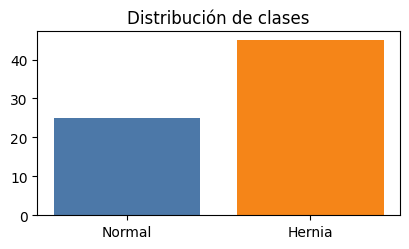

In [42]:
# Etapa 3) Cargar datos y ver cuántos hay por clase
# Mini-resumen: cargamos el dataset y auditamos distribución de clases para anticipar sesgos de entrenamiento.
# Paso 1: cargamos todas las imágenes y sus etiquetas desde la estructura de carpetas.
# Esto crea una lista estandarizada de objetos `Muestra` para todo el pipeline.
muestras = construir_muestras_desde_carpetas(RUTA_IMAGENES)
# Paso 2: extraemos vectores rápidos (etiquetas e IDs) para auditoría estadística.
# Hacer esto al inicio evita sorpresas de desbalance más adelante.
etiquetas = np.array([m.etiqueta for m in muestras], dtype=int)
# IDs aproximados ayudan a revisar posible repetición de casos.
ids_paciente = np.array([m.id_paciente for m in muestras])

# Paso 3: imprimimos un chequeo básico del dataset cargado.
print('Fuente:', RUTA_IMAGENES)
print('Total:', len(muestras))
print('Normal:', int((etiquetas == 0).sum()))
print('Hernia:', int((etiquetas == 1).sum()))
print('IDs únicos (aprox):', len(np.unique(ids_paciente)))

# Paso 4: graficamos distribución de clases para ver si hay sesgo fuerte.
# Este gráfico orienta decisiones como ponderación de pérdida o ajuste de umbral.
fig, ax = plt.subplots(figsize=(4.2, 2.6))
ax.bar(['Normal', 'Hernia'], [(etiquetas == 0).sum(), (etiquetas == 1).sum()], color=['#4C78A8', '#F58518'])
ax.set_title('Distribución de clases')
plt.tight_layout()
plt.show()


<a id="etapa-4"></a>
## Etapa 4: Inspección visual rápida

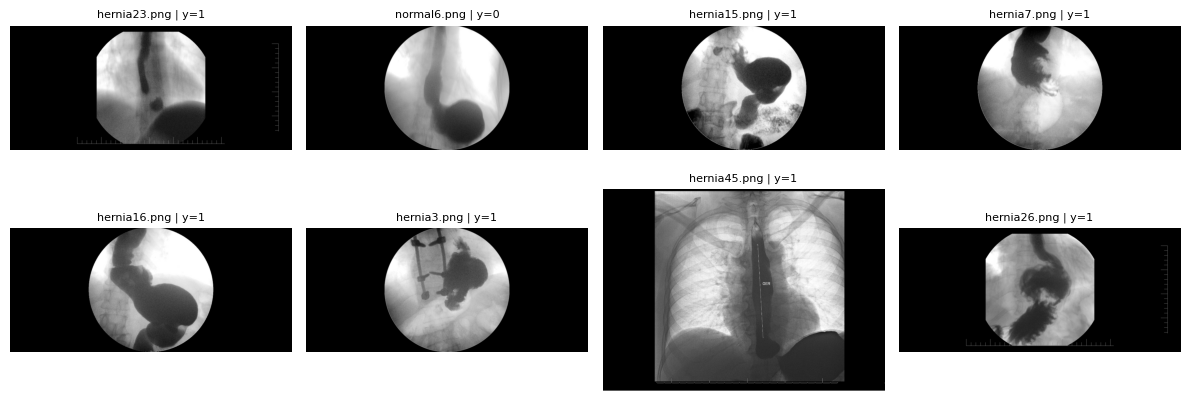

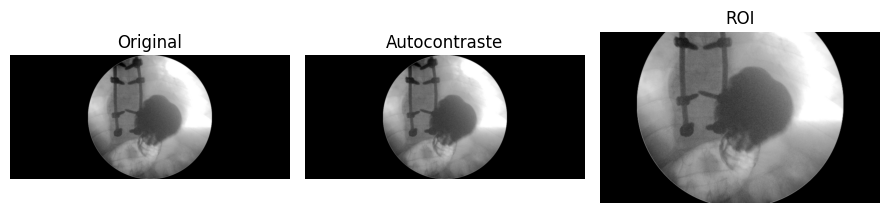

In [43]:
# Etapa 4) Inspección visual rápida
# Mini-resumen: inspeccionamos muestras para validar calidad de entrada y coherencia del preprocesamiento.
# Inspección visual temprana: detecta etiquetas dudosas, artefactos o rutas incorrectas antes de entrenar.

# Seleccionamos un subconjunto aleatorio de imágenes para inspección manual.
# La inspección visual temprana es una defensa simple contra errores de datos.
indices_muestra = list(range(len(muestras)))
random.Random(SEMILLA).shuffle(indices_muestra)
indices_muestra = indices_muestra[:min(8, len(indices_muestra))]

# Armamos una grilla compacta para revisar varias muestras al mismo tiempo.
n_cols = 4
n_rows = int(np.ceil(len(indices_muestra) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.0 * n_cols, 2.2 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)

# Apagamos ejes para priorizar lectura visual de las imágenes.
for ax in axes.flat:
    ax.axis('off')

# Dibujamos cada muestra con su etiqueta para validar coherencia imagen/label.
for ax, idx in zip(axes.flat, indices_muestra):
    muestra = muestras[idx]
    with Image.open(muestra.ruta) as imagen:
        ax.imshow(imagen.convert('L'), cmap='gray')
    ax.set_title(f'{muestra.ruta.name} | y={muestra.etiqueta}', fontsize=8)

plt.tight_layout()
plt.show()

# Comparativa de preprocesamiento: original -> autocontraste -> ROI para verificar impacto visual.
# Elegimos un ejemplo de referencia para comparar etapas de preprocesamiento.
ejemplo = muestras[0]
with Image.open(ejemplo.ruta) as imagen:
    gris = imagen.convert('L')

# Aplicamos exactamente la misma idea de preprocesamiento que verá el modelo.
# Así comprobamos visualmente qué información se conserva o se resalta.
auto = ImageOps.autocontrast(gris) if USAR_AUTOCONTRASTE else gris
roi = RecorteRetrocardiaco()(Image.merge('RGB', (auto, auto, auto))).convert('L') if USAR_ROI else auto

# Comparativa lado a lado: original vs autocontraste vs ROI.
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for ax, img, titulo in zip(axes, [gris, auto, roi], ['Original', 'Autocontraste', 'ROI']):
    ax.imshow(img, cmap='gray')
    ax.set_title(titulo)
    ax.axis('off')
plt.tight_layout()
plt.show()


<a id="etapa-5"></a>
## Etapa 5: Split y DataLoaders

In [44]:
# Etapa 5) Split y DataLoaders
# Mini-resumen: definimos particiones y DataLoaders para un flujo de entrenamiento reproducible.
# Usamos un fold demo para iteración rápida antes de ejecutar validación cruzada completa.

# Construimos folds estratificados para preservar proporción de clases en train/val.
pliegues, nombre_split = construir_pliegues(muestras, n_splits=N_SPLITS, semilla=SEMILLA)
print('Split:', nombre_split)

# Tomamos el primer fold como escenario demo para iterar rápido.
indices_entrenamiento, indices_validacion = pliegues[0]
print('Fold demo train/val:', len(indices_entrenamiento), len(indices_validacion))

# Definimos transformaciones de train y validación de forma explícita.
# Separarlas evita contaminación de augmentaciones en evaluación.
transf_entrenamiento, transf_validacion, transf_visual = construir_transformaciones(
    tam_imagen=TAM_IMAGEN,
    usar_roi=USAR_ROI,
    usar_aug_train=USAR_AUMENTACION_TRAIN,
)

# Envolvemos índices de cada split en datasets de PyTorch para acceso por lotes.
dataset_entrenamiento = ConjuntoHiatal(muestras, indices_entrenamiento, transf_entrenamiento)
dataset_validacion = ConjuntoHiatal(muestras, indices_validacion, transf_validacion)

# Loader de train: mezcla y entrega batches para optimización estocástica.
loader_entrenamiento = crear_loader_entrenamiento(
    dataset_entrenamiento,
    tam_batch=TAM_BATCH,
    num_workers=0,  # En notebook usamos 0 para evitar problemas de multiprocessing.
    dispositivo=DISPOSITIVO,
    factor_muestras_epoca=FACTOR_MUESTRAS_ENTRENAMIENTO_POR_EPOCA,
)

# Loader de validación: sin shuffle para mantener evaluación determinista.
loader_validacion = DataLoader(
    dataset_validacion,
    batch_size=TAM_BATCH,
    shuffle=False,
    num_workers=0,
    pin_memory=(DISPOSITIVO.type == 'cuda'),
)

# Smoke test: verificamos forma de tensores antes de iniciar entrenamiento.
lote_x, lote_y, _ = next(iter(loader_entrenamiento))
# Reporte rápido para verificar que el split quedó bien formado.
print('Dataset train:', len(dataset_entrenamiento))
print('Dataset val:', len(dataset_validacion))
print('Batch x:', tuple(lote_x.shape), '| Batch y:', tuple(lote_y.shape))


Split: StratifiedKFold
Fold demo train/val: 56 14
Dataset train: 56
Dataset val: 14
Batch x: (8, 3, 512, 512) | Batch y: (8,)


<a id="etapa-6"></a>
## Etapa 6: Preparar modelo, pérdida y optimizador

In [45]:
# Etapa 6) Preparar modelo, pérdida y optimizador
# Mini-resumen: inicializamos arquitectura, criterio y optimización con una configuración estable.

# Inicializamos el modelo en el dispositivo seleccionado.
modelo = crear_modelo(preentrenado=USAR_PREENTRENADO, dropout=DROPOUT).to(DISPOSITIVO)
print('Estructura del modelo:')
print(modelo)

# Fase de warm-up: congelamos backbone para adaptar la cabeza clasificadora sin perturbar todo el extractor.
if EPOCAS_CONGELADAS > 0:
    fijar_backbone_entrenable(modelo, False)

# Optimizador principal: AdamW por buen compromiso entre convergencia y regularización.
optimizador = torch.optim.AdamW(modelo.parameters(), lr=3e-4, weight_decay=1e-4)
planificador = torch.optim.lr_scheduler.CosineAnnealingLR(optimizador, T_max=max(1, EPOCAS))

# Función de pérdida: BCE con `pos_weight` para compensar desbalance de etiquetas.
peso_positivo = calcular_peso_positivo(muestras, indices_entrenamiento, DISPOSITIVO)
criterio = nn.BCEWithLogitsLoss(pos_weight=peso_positivo)

# AMP se activa solo en CUDA para reducir costo computacional manteniendo estabilidad numérica.
escalador = crear_escalador_amp(DISPOSITIVO, USAR_AMP)

# Iniciamos una única corrida MLflow para centralizar trazabilidad del experimento.
# Registramos parámetros iniciales para trazabilidad del experimento.
mlflow_iniciar_run({
    'tam_imagen': TAM_IMAGEN,
    'tam_batch': TAM_BATCH,
    'epocas': EPOCAS,
    'epocas_congeladas': EPOCAS_CONGELADAS,
    'paciencia': PACIENCIA,
    'usar_preentrenado': USAR_PREENTRENADO,
    'usar_roi': USAR_ROI,
    'usar_autocontraste': USAR_AUTOCONTRASTE,
    'usar_aumentacion_train': USAR_AUMENTACION_TRAIN,
    'optimizar_umbral': OPTIMIZAR_UMBRAL,
    'run_cv_completo': RUN_CV_COMPLETO,
    'dispositivo': str(DISPOSITIVO),
    'num_muestras': len(muestras),
    'factor_muestras_epoca': FACTOR_MUESTRAS_ENTRENAMIENTO_POR_EPOCA,
    'usar_ensemble_cv': USAR_ENSEMBLE_CV,
    'mlflow_modo': MLFLOW_MODO,
    'mlflow_tracking_uri': MLFLOW_TRACKING_URI,
    'mlflow_experimento': MLFLOW_EXPERIMENTO,
    'mlflow_log_modelo': MLFLOW_REGISTRAR_MODELO,
    'mlflow_auto_start_local_server': MLFLOW_AUTO_INICIAR_SERVIDOR_LOCAL,
    'mlflow_stop_local_server_at_end': MLFLOW_DETENER_SERVIDOR_LOCAL_AL_FINAL,
})


Estructura del modelo:
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_st

<a id="etapa-7"></a>
## Etapa 7: Entrenamiento del fold demo

In [46]:
# Etapa 7) Entrenamiento del fold demo
# Mini-resumen: optimizamos por épocas, validamos en cada ciclo y conservamos el mejor checkpoint.
#
# Aquí se ejecuta el ciclo de aprendizaje supervisado:
# en cada época entrenamos y luego evaluamos en validación para medir generalización,
# guardando el mejor estado para evitar degradación por sobreajuste tardío.
#
# Esta estrategia prioriza estabilidad y control experimental:
# - early stopping limita sobreajuste,
# - selección por AUC/F1 evita depender exclusivamente de loss,
# - historial por época permite auditoría y diagnóstico posterior.

historial = []
mejor = None
epocas_sin_mejora = 0

for epoca in range(1, EPOCAS + 1):
    # Tras el warm-up, descongelamos backbone para fine-tuning completo.
    if EPOCAS_CONGELADAS > 0 and epoca == EPOCAS_CONGELADAS + 1:
        fijar_backbone_entrenable(modelo, True)

    perdida_train, _, _ = ejecutar_epoca(
        modelo,
        loader_entrenamiento,
        criterio,
        DISPOSITIVO,
        optimizador=optimizador,
        escalador_amp=escalador,
    )

    perdida_val, _, _ = ejecutar_epoca(
        modelo,
        loader_validacion,
        criterio,
        DISPOSITIVO,
        optimizador=None,
        escalador_amp=None,
    )

    # Predicción de validación usada para umbral y métricas de la época.
    y_val, p_val, _ = predecir_loader(modelo, loader_validacion, DISPOSITIVO)
    umbral = buscar_umbral_optimo(y_val, p_val) if OPTIMIZAR_UMBRAL else 0.5
    metricas = calcular_metricas(y_val, p_val, umbral=umbral)

    # Guardamos snapshot de métricas por época para análisis posterior.
    fila = {
        'epoca': epoca,
        'perdida_train': float(perdida_train),
        'perdida_val': float(perdida_val),
        'auc': float(metricas['auc']) if np.isfinite(metricas['auc']) else np.nan,
        'f1': float(metricas['f1']),
        'sensibilidad': float(metricas['sensibilidad']) if np.isfinite(metricas['sensibilidad']) else np.nan,
        'especificidad': float(metricas['especificidad']) if np.isfinite(metricas['especificidad']) else np.nan,
        'umbral': float(umbral),
    }
    historial.append(fila)

    # Selección de checkpoint por AUC; si no es computable, usamos F1 como criterio de respaldo.
    score = fila['auc'] if np.isfinite(fila['auc']) else fila['f1']

    if mejor is None or score > mejor['score']:
        mejor = {
            'score': float(score),
            'state_dict': {k: v.detach().cpu().clone() for k, v in modelo.state_dict().items()},
            'metricas': dict(fila),
        }
        epocas_sin_mejora = 0
    else:
        epocas_sin_mejora += 1

    # Enviamos métricas de época a MLflow para seguimiento temporal.
    mlflow_log_metricas(
        {
            'loss_train': fila['perdida_train'],
            'loss_val': fila['perdida_val'],
            'auc': fila['auc'],
            'f1': fila['f1'],
            'sensibilidad': fila['sensibilidad'],
            'especificidad': fila['especificidad'],
            'umbral': fila['umbral'],
            'score': score,
        },
        prefijo='demo.epoch',
        step=epoca,
    )

    # Actualizamos scheduler de learning rate al final de cada época.
    planificador.step()

    print(
        f"Ep {epoca:02d} | train={perdida_train:.4f} val={perdida_val:.4f} "
        f"auc={fila['auc']:.4f} f1={fila['f1']:.4f} "
        f"sens={fila['sensibilidad']:.4f} esp={fila['especificidad']:.4f} "
        f"thr={fila['umbral']:.3f}"
    )

    if epocas_sin_mejora >= PACIENCIA:
        print(f'Early stopping en época {epoca}')
        break

if mejor is None:
    raise RuntimeError('No se encontró un mejor modelo durante entrenamiento.')

# Cargamos inmediatamente el mejor estado para garantizar coherencia en etapas siguientes.
modelo.load_state_dict(mejor['state_dict'])
modelo.to(DISPOSITIVO)
modelo.eval()

print('Mejor época:', mejor['metricas'])

# Persistimos historial por época en CSV para trazabilidad y análisis externo.
df_historial = pd.DataFrame(historial)
ruta_historial = RUTA_SALIDA / 'historial_fold_demo.csv'
df_historial.to_csv(ruta_historial, index=False)
mlflow_log_artifact(ruta_historial)
mlflow_log_metricas(mejor['metricas'], prefijo='demo.best')


Ep 01 | train=1.0026 val=0.5024 auc=0.5778 f1=0.7778 sens=0.7778 esp=0.6000 thr=0.408
Ep 02 | train=0.9573 val=0.5021 auc=0.4444 f1=0.8182 sens=1.0000 esp=0.2000 thr=0.416
Ep 03 | train=0.8150 val=0.3663 auc=0.8667 f1=0.8000 sens=0.6667 esp=1.0000 thr=0.635
Ep 04 | train=0.4128 val=0.2515 auc=1.0000 f1=1.0000 sens=1.0000 esp=1.0000 thr=0.844
Ep 05 | train=0.2910 val=0.1819 auc=1.0000 f1=1.0000 sens=1.0000 esp=1.0000 thr=0.870
Ep 06 | train=0.1312 val=0.1674 auc=1.0000 f1=1.0000 sens=1.0000 esp=1.0000 thr=0.965
Ep 07 | train=0.0697 val=0.1266 auc=0.9778 f1=0.9412 sens=0.8889 esp=1.0000 thr=0.958
Ep 08 | train=0.0872 val=0.2876 auc=0.9111 f1=0.9474 sens=1.0000 esp=0.8000 thr=0.348
Ep 09 | train=0.0977 val=0.1159 auc=1.0000 f1=1.0000 sens=1.0000 esp=1.0000 thr=0.263
Ep 10 | train=0.1066 val=0.1509 auc=0.9778 f1=0.9412 sens=0.8889 esp=1.0000 thr=0.760
Ep 11 | train=0.0900 val=0.0628 auc=1.0000 f1=1.0000 sens=1.0000 esp=1.0000 thr=0.929
Ep 12 | train=0.0636 val=0.0589 auc=1.0000 f1=1.0000 s

<a id="etapa-8"></a>
## Etapa 8: Curvas de entrenamiento

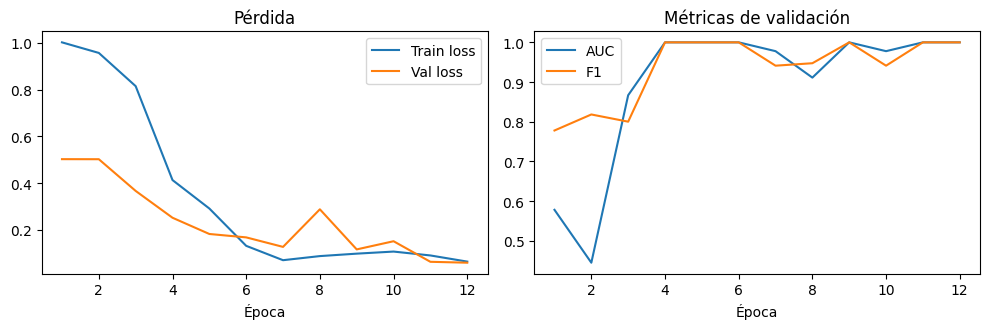

In [47]:
# Etapa 8) Curvas de entrenamiento
# Mini-resumen: visualizamos dinámica de entrenamiento para detectar convergencia, estancamiento o sobreajuste.

# Si no hubo entrenamiento, evitamos intentar graficar estructuras vacías.
if len(historial) == 0:
    print('No hay historial para graficar.')
else:
    # Convertimos historial a DataFrame para graficar fácilmente.
    df_h = pd.DataFrame(historial)

    # Panel doble: pérdidas (izquierda) y métricas de validación (derecha).
    # Esto permite detectar convergencia y brecha de generalización en una sola vista.
    fig, axes = plt.subplots(1, 2, figsize=(10, 3.4))

    axes[0].plot(df_h['epoca'], df_h['perdida_train'], label='Train loss')
    axes[0].plot(df_h['epoca'], df_h['perdida_val'], label='Val loss')
    axes[0].set_title('Pérdida')
    axes[0].set_xlabel('Época')
    axes[0].legend()

    axes[1].plot(df_h['epoca'], df_h['auc'], label='AUC')
    axes[1].plot(df_h['epoca'], df_h['f1'], label='F1')
    axes[1].set_title('Métricas de validación')
    axes[1].set_xlabel('Época')
    axes[1].legend()

    plt.tight_layout()

    # Guardamos la figura para reporte y trazabilidad fuera del notebook.
    ruta_curvas = RUTA_SALIDA / 'curvas_entrenamiento_demo.png'
    guardar_figura(fig, ruta_curvas)
    plt.show()



<a id="etapa-9"></a>
## Etapa 9: Evaluación del fold demo + guardado de predicciones

Métricas fold demo:
- auc: 1.0
- accuracy: 1.0
- f1: 1.0
- sensibilidad: 1.0
- especificidad: 1.0
- tp: 9
- tn: 5
- fp: 0
- fn: 0
- umbral: 0.8437250256538391
Guardado: /Users/ra/Library/CloudStorage/GoogleDrive-ricardoaarango@gmail.com/My Drive/Educacion/U de los Andes/MAIA/IV/Proyecto - Desarrollo de Soluciones/maia_proyecto_desarrollo_soluciones/outputs/hiatal_notebook/val_predictions_demo.csv


2026/02/13 14:59:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/13 14:59:46 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


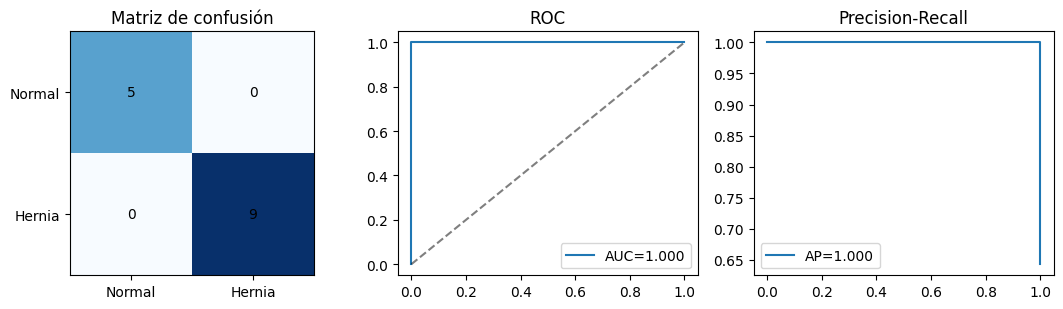

In [48]:
# Etapa 9) Evaluación del fold demo + guardado de predicciones
# Mini-resumen: cerramos evaluación del fold demo y persistimos outputs para auditoría.

# Usamos el umbral del mejor checkpoint para convertir probabilidades en clases.
umbral_demo = float(mejor['metricas']['umbral'])
# Ejecutamos evaluación final del fold demo con el mejor modelo cargado.
y_real_demo, p_demo, rutas_demo = predecir_loader(modelo, loader_validacion, DISPOSITIVO)
y_pred_demo = (p_demo >= umbral_demo).astype(int)

# Calculamos métricas centrales del fold demo con el mismo umbral operativo.
metricas_demo = calcular_metricas(y_real_demo, p_demo, umbral=umbral_demo)
print('Métricas fold demo:')
for clave in ['auc', 'accuracy', 'f1', 'sensibilidad', 'especificidad', 'tp', 'tn', 'fp', 'fn', 'umbral']:
    print(f'- {clave}: {metricas_demo[clave]}')

# Registramos métricas en MLflow para comparar corridas históricas.
mlflow_log_metricas(metricas_demo, prefijo='demo.val')

# Guardamos predicciones por imagen para análisis de errores a nivel de caso.
# Construimos tabla por imagen (verdadero, predicción y probabilidad).
# Esta tabla es clave para análisis posterior de errores clínicos.
pred_df = pd.DataFrame({
    'image_path': rutas_demo,
    'y_true': y_real_demo,
    'y_pred': y_pred_demo,
    'probability': p_demo,
    'threshold': umbral_demo,
})
# Marcamos aciertos por fila para análisis de casos difíciles.
pred_df['correct'] = (pred_df['y_true'] == pred_df['y_pred']).astype(int)

ruta_pred = RUTA_SALIDA / 'val_predictions_demo.csv'
pred_df.to_csv(ruta_pred, index=False)
mlflow_log_artifact(ruta_pred)
print('Guardado:', ruta_pred)

# Guardamos checkpoint reproducible (pesos + umbral + metadatos de configuración).
# Exportamos checkpoint para reutilizar modelo sin reentrenar.
ruta_ckpt_demo = RUTA_SALIDA / 'best_model_fold_demo.pt'
torch.save(
    {
        'state_dict': mejor['state_dict'],
        'umbral_demo': umbral_demo,
        'metricas_demo': metricas_demo,
        'config': {
            'tam_imagen': TAM_IMAGEN,
            'usar_roi': USAR_ROI,
            'usar_autocontraste': USAR_AUTOCONTRASTE,
            'criterio': 'bce_with_logits_pos_weight',
        },
    },
    ruta_ckpt_demo,
)
mlflow_log_artifact(ruta_ckpt_demo)
mlflow_log_modelo_pytorch(modelo, nombre_modelo='modelo_fold_demo')

# Figuras diagnósticas de evaluación.
# Matriz de confusión: resume qué tipo de error comete el modelo.
matriz = confusion_matrix(y_real_demo, y_pred_demo, labels=[0, 1])
fig, axes = plt.subplots(1, 3, figsize=(11, 3.2))

dibujar_matriz_confusion(axes[0], matriz, 'Matriz de confusión')

# ROC/PR solo tienen sentido cuando hay ambas clases en validación.
if len(np.unique(y_real_demo)) > 1:
    ax = axes[1]
    fpr, tpr, _ = roc_curve(y_real_demo, p_demo)
    ax.plot(fpr, tpr, label=f"AUC={auc(fpr, tpr):.3f}")
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.legend(loc='lower right')
    ax.set_title('ROC')

    ax = axes[2]
    precision, recall, _ = precision_recall_curve(y_real_demo, p_demo)
    ap = average_precision_score(y_real_demo, p_demo)
    ax.plot(recall, precision, label=f"AP={ap:.3f}")
    ax.legend(loc='lower left')
    ax.set_title('Precision-Recall')
else:
    axes[1].axis('off')
    axes[1].text(0.5, 0.5, 'ROC no disponible | una sola clase', ha='center', va='center')
    axes[2].axis('off')
    axes[2].text(0.5, 0.5, 'PR no disponible | una sola clase', ha='center', va='center')

plt.tight_layout()

# Guardamos panel de evaluación como artefacto del experimento.
ruta_eval_demo = RUTA_SALIDA / 'fold_demo_eval.png'
guardar_figura(fig, ruta_eval_demo)
plt.show()



<a id="etapa-10"></a>
## Etapa 10: Interpretabilidad con Grad-CAM (ejemplos TP/TN/FP/FN)

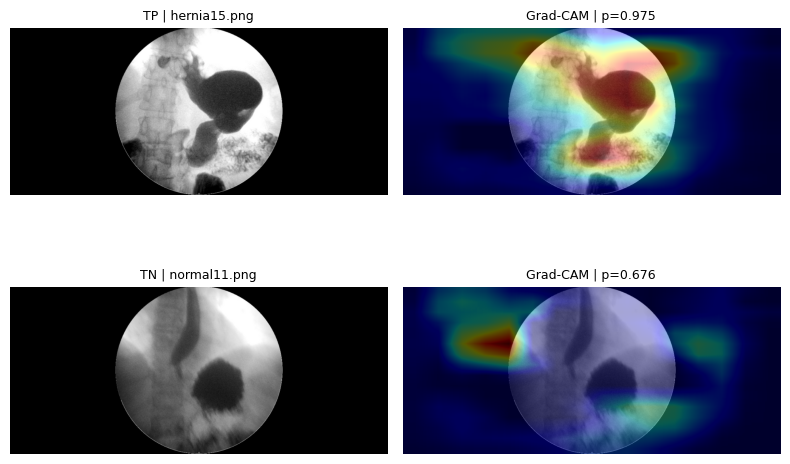

In [49]:
# Etapa 10) Interpretabilidad con Grad-CAM (ejemplos TP/TN/FP/FN)
# Mini-resumen: usamos Grad-CAM en aciertos/errores para analizar patrones de atención del modelo.

# Grad-CAM es opcional porque puede consumir tiempo extra de cómputo.
if not MOSTRAR_GRADCAM:
    print('MOSTRAR_GRADCAM=False (se omite esta etapa).')
else:
    # Agrupamos índices por tipo de resultado: TP, TN, FP, FN.
    casos = {
        'TP': [],
        'TN': [],
        'FP': [],
        'FN': [],
    }

    # Recorremos predicciones para clasificar cada caso según la matriz de confusión.
    for i, (yt, yp) in enumerate(zip(y_real_demo, y_pred_demo)):
        if yt == 1 and yp == 1:
            casos['TP'].append(i)
        elif yt == 0 and yp == 0:
            casos['TN'].append(i)
        elif yt == 0 and yp == 1:
            casos['FP'].append(i)
        elif yt == 1 and yp == 0:
            casos['FN'].append(i)

    # Tomamos un ejemplo representativo por categoría para no saturar la visualización.
    seleccion = []
    for nombre in ['TP', 'TN', 'FP', 'FN']:
        if casos[nombre]:
            seleccion.append((nombre, casos[nombre][0]))

    # Si no hay casos disponibles, cerramos la etapa con mensaje explícito.
    if len(seleccion) == 0:
        print('No hay casos para mostrar Grad-CAM en este fold.')
    else:
        fig, axes = plt.subplots(len(seleccion), 2, figsize=(8, 3.0 * len(seleccion)))
        axes = asegurar_matriz_axes(axes, len(seleccion), 2)

        # Renderizamos cada caso con imagen original y superposición Grad-CAM.
        for fila, (tipo, idx) in enumerate(seleccion):
            ruta = Path(rutas_demo[idx])
            with Image.open(ruta) as img:
                rgb = img.convert('RGB')
                gris = rgb.convert('L')

            overlay, prob = superponer_gradcam(rgb, modelo, transf_validacion)

            axes[fila, 0].imshow(gris, cmap='gray')
            axes[fila, 0].set_title(f'{tipo} | {ruta.name}', fontsize=9)
            axes[fila, 0].axis('off')

            axes[fila, 1].imshow(overlay)
            axes[fila, 1].set_title(f'Grad-CAM | p={prob:.3f}', fontsize=9)
            axes[fila, 1].axis('off')

        plt.tight_layout()

        # Guardamos panel Grad-CAM para discusión clínica posterior.
        ruta_gradcam = RUTA_SALIDA / 'gradcam_tp_tn_fp_fn.png'
        guardar_figura(fig, ruta_gradcam)
        plt.show()



<a id="etapa-11"></a>
## Etapa 11: Validación cruzada completa (opcional)

In [50]:
# Etapa 11) Validación cruzada completa (opcional)
# Mini-resumen: estimamos robustez poblacional mediante entrenamiento y evaluación en múltiples folds.
#
# La validación cruzada responde una pregunta metodológica clave:
# "¿el buen desempeño depende de un split favorable o se sostiene entre particiones?"
#
# En lugar de depender de un único fold, entrenamos múltiples folds y agregamos
# predicciones OOF (out-of-fold), obteniendo una estimación menos optimista
# del desempeño esperado ante nuevos datos.

# La CV completa es costosa, por eso se controla con bandera explícita.
estados_cv = []
modelos_ensemble_cv = []
if RUN_CV_COMPLETO:
    pliegues_cv, nombre_split_cv = construir_pliegues(muestras, n_splits=N_SPLITS, semilla=SEMILLA)
    print('CV:', nombre_split_cv, '| folds:', len(pliegues_cv))

    # `probs_oof` almacenará la probabilidad de cada muestra cuando actuó como validación.
    # Esto evita leakage y permite estimación global más realista.
    probs_oof = np.zeros(len(muestras), dtype=np.float32)
    metricas_folds = []

    # Bucle externo de CV: cada fold redefine train/val de forma independiente.
    for id_fold, (idx_train, idx_val) in enumerate(pliegues_cv, start=1):
        print()
        print(f"=== Fold {id_fold:02d}/{len(pliegues_cv)} train={len(idx_train)} val={len(idx_val)} ===")

        # Reinstanciamos transformaciones por fold para mantener aislamiento del experimento.
        transf_train_cv, transf_val_cv, _ = construir_transformaciones(
            tam_imagen=TAM_IMAGEN,
            usar_roi=USAR_ROI,
            usar_aug_train=USAR_AUMENTACION_TRAIN,
        )

        ds_train_cv = ConjuntoHiatal(muestras, idx_train, transf_train_cv)
        ds_val_cv = ConjuntoHiatal(muestras, idx_val, transf_val_cv)

        # DataLoaders específicos del fold actual.
        loader_train_cv = crear_loader_entrenamiento(
            ds_train_cv,
            tam_batch=TAM_BATCH,
            num_workers=0,
            dispositivo=DISPOSITIVO,
            factor_muestras_epoca=FACTOR_MUESTRAS_ENTRENAMIENTO_POR_EPOCA,
        )

        loader_val_cv = DataLoader(
            ds_val_cv,
            batch_size=TAM_BATCH,
            shuffle=False,
            num_workers=0,
            pin_memory=(DISPOSITIVO.type == 'cuda'),
        )

        # Modelo nuevo por fold: no se comparten pesos entre folds.
        modelo_fold = crear_modelo(preentrenado=USAR_PREENTRENADO, dropout=DROPOUT).to(DISPOSITIVO)
        if EPOCAS_CONGELADAS > 0:
            fijar_backbone_entrenable(modelo_fold, False)

        # Optimizador y scheduler se reinician en cada fold para consistencia estadística.
        optimizador_fold = torch.optim.AdamW(modelo_fold.parameters(), lr=3e-4, weight_decay=1e-4)
        planificador_fold = torch.optim.lr_scheduler.CosineAnnealingLR(optimizador_fold, T_max=max(1, EPOCAS))

        # Recalculamos balance de clase por fold para evitar sesgo local.
        peso_pos_fold = calcular_peso_positivo(muestras, idx_train, DISPOSITIVO)
        criterio_fold = nn.BCEWithLogitsLoss(pos_weight=peso_pos_fold)
        escalador_fold = crear_escalador_amp(DISPOSITIVO, USAR_AMP)

        # Estructuras de selección temprana del mejor checkpoint del fold.
        mejor_fold = None
        sin_mejora_fold = 0

        # Bucle interno de entrenamiento para el fold actual.
        for epoca in range(1, EPOCAS + 1):
            if EPOCAS_CONGELADAS > 0 and epoca == EPOCAS_CONGELADAS + 1:
                fijar_backbone_entrenable(modelo_fold, True)

            ejecutar_epoca(modelo_fold, loader_train_cv, criterio_fold, DISPOSITIVO, optimizador=optimizador_fold, escalador_amp=escalador_fold)
            ejecutar_epoca(modelo_fold, loader_val_cv, criterio_fold, DISPOSITIVO, optimizador=None, escalador_amp=None)

            # Evaluación por época sobre validación del fold.
            y_val_fold, p_val_fold, _ = predecir_loader(modelo_fold, loader_val_cv, DISPOSITIVO)
            umbral_fold = buscar_umbral_optimo(y_val_fold, p_val_fold) if OPTIMIZAR_UMBRAL else 0.5
            met_fold = calcular_metricas(y_val_fold, p_val_fold, umbral=umbral_fold)

            # Criterio de selección: AUC si está definida; F1 como fallback robusto.
            score_fold = met_fold['auc'] if np.isfinite(met_fold['auc']) else met_fold['f1']

            if mejor_fold is None or score_fold > mejor_fold['score']:
                mejor_fold = {
                    'score': float(score_fold),
                    'state_dict': {k: v.detach().cpu().clone() for k, v in modelo_fold.state_dict().items()},
                    'umbral': float(umbral_fold),
                    'epoca': epoca,
                }
                sin_mejora_fold = 0
            # Si no mejora en esta época, incrementamos contador de paciencia.
            else:
                sin_mejora_fold += 1

            planificador_fold.step()
            if sin_mejora_fold >= PACIENCIA:
                break

        # Restauramos el mejor estado antes de generar métricas finales del fold.
        modelo_fold.load_state_dict(mejor_fold['state_dict'])
        y_val_fold, p_val_fold, _ = predecir_loader(modelo_fold, loader_val_cv, DISPOSITIVO)
        met_final_fold = calcular_metricas(y_val_fold, p_val_fold, umbral=mejor_fold['umbral'])

        # Añadimos metadatos del fold para auditoría y comparación.
        met_final_fold['fold'] = int(id_fold)
        met_final_fold['best_epoch'] = int(mejor_fold['epoca'])
        met_final_fold['best_threshold'] = float(mejor_fold['umbral'])
        metricas_folds.append(met_final_fold)

        # Guardamos estado del mejor modelo de este fold para construir ensemble.
        estados_cv.append({k: v.detach().cpu().clone() for k, v in mejor_fold['state_dict'].items()})

        # Guardamos predicciones OOF respetando la posición original de cada muestra.
        probs_oof[idx_val] = p_val_fold.astype(np.float32)
        mlflow_log_metricas(met_final_fold, prefijo=f'cv.fold_{id_fold}')

    # Construimos ensemble de folds para usarlo en evaluación final e inferencia.
    if USAR_ENSEMBLE_CV and len(estados_cv) > 0:
        modelos_ensemble_cv = construir_modelos_ensemble(estados_cv, DISPOSITIVO)
        print(f'Ensemble CV activo con {len(modelos_ensemble_cv)} modelos.')

    # Con todas las OOF, calculamos métrica global sin contaminación train/val.
    y_global = np.array([m.etiqueta for m in muestras], dtype=int)
    umbral_global = buscar_umbral_optimo(y_global, probs_oof) if OPTIMIZAR_UMBRAL else 0.5
    metricas_oof = calcular_metricas(y_global, probs_oof, umbral=umbral_global)

    # Resumen agregado (media y desviación) para cuantificar estabilidad entre folds.
    resumen_cv = {}
    for nombre_metrica in ['auc', 'accuracy', 'f1', 'sensibilidad', 'especificidad']:
        valores = [float(m[nombre_metrica]) for m in metricas_folds]
        resumen_cv[f'{nombre_metrica}_mean'] = float(np.nanmean(valores))
        resumen_cv[f'{nombre_metrica}_std'] = float(np.nanstd(valores))

    # Exportamos tabla OOF para análisis fino por muestra.
    df_oof = pd.DataFrame({
        'image_path': [str(m.ruta) for m in muestras],
        'patient_id': [m.id_paciente for m in muestras],
        'label': [m.etiqueta for m in muestras],
        'probability': probs_oof,
    })
    df_oof['prediction'] = (df_oof['probability'] >= umbral_global).astype(int)

    # Exportamos OOF para inspección caso a caso fuera del notebook.
    ruta_oof = RUTA_SALIDA / 'oof_predictions.csv'
    df_oof.to_csv(ruta_oof, index=False)

    # Consolidamos todo en un JSON para reporte reproducible.
    resumen = {
        'num_samples': int(len(muestras)),
        'num_normal': int((y_global == 0).sum()),
        'num_hiatal_hernia': int((y_global == 1).sum()),
        'device': str(DISPOSITIVO),
        'split_strategy': nombre_split_cv,
        'fold_metrics': metricas_folds,
        'cv_summary': resumen_cv,
        'oof_metrics': metricas_oof,
        'global_threshold': float(umbral_global),
        'usar_roi': bool(USAR_ROI),
        'usar_autocontraste': bool(USAR_AUTOCONTRASTE),
        'usar_ensemble_cv': bool(USAR_ENSEMBLE_CV),
        'n_modelos_ensemble': int(len(modelos_ensemble_cv)),
    }

    # Exportamos resumen global para reporte reproducible.
    ruta_resumen = RUTA_SALIDA / 'metrics_summary.json'
    ruta_resumen.write_text(json.dumps(resumen, indent=2), encoding='utf-8')

    # Registramos métricas/artefactos de CV en MLflow.
    mlflow_log_metricas(metricas_oof, prefijo='cv.oof')
    mlflow_log_metricas(resumen_cv, prefijo='cv.summary')
    mlflow_log_metricas({'global_threshold': umbral_global}, prefijo='cv')
    mlflow_log_artifact(ruta_oof)
    mlflow_log_artifact(ruta_resumen)

    print('CV summary:', resumen_cv)
    print('OOF metrics:', metricas_oof)
    print('Guardado en:', RUTA_SALIDA)
# Si RUN_CV_COMPLETO es False, saltamos CV para acelerar pruebas rápidas.
else:
    estados_cv = []
    modelos_ensemble_cv = []
    print('RUN_CV_COMPLETO=False (no se ejecutó CV completo)')


CV: StratifiedKFold | folds: 5

=== Fold 01/5 train=56 val=14 ===

=== Fold 02/5 train=56 val=14 ===

=== Fold 03/5 train=56 val=14 ===

=== Fold 04/5 train=56 val=14 ===

=== Fold 05/5 train=56 val=14 ===
Ensemble CV activo con 5 modelos.
CV summary: {'auc_mean': 1.0, 'auc_std': 0.0, 'accuracy_mean': 1.0, 'accuracy_std': 0.0, 'f1_mean': 1.0, 'f1_std': 0.0, 'sensibilidad_mean': 1.0, 'sensibilidad_std': 0.0, 'especificidad_mean': 1.0, 'especificidad_std': 0.0}
OOF metrics: {'umbral': 0.5917797684669495, 'auc': 0.9706666666666666, 'accuracy': 0.9142857142857143, 'f1': 0.9302325581395349, 'sensibilidad': 0.8888888888888888, 'especificidad': 0.96, 'tp': 40, 'tn': 24, 'fp': 1, 'fn': 5}
Guardado en: /Users/ra/Library/CloudStorage/GoogleDrive-ricardoaarango@gmail.com/My Drive/Educacion/U de los Andes/MAIA/IV/Proyecto - Desarrollo de Soluciones/maia_proyecto_desarrollo_soluciones/outputs/hiatal_notebook


<a id="etapa-12"></a>
## Etapa 12: Lectura clínica rápida (explicación humana)

In [51]:
# Etapa 12) Lectura clínica rápida (explicación humana)
# Mini-resumen: traducimos métricas técnicas a una lectura clínica interpretables para decisión operativa.

# Mostramos contexto operativo para interpretar métricas con su configuración.
print('Contexto de ejecución:')
print(f"- Dispositivo: {DISPOSITIVO}")
print(f"- Imagen: {TAM_IMAGEN}x{TAM_IMAGEN} | Batch: {TAM_BATCH}")
print(f"- Preentrenado: {USAR_PREENTRENADO} | ROI: {USAR_ROI} | Autocontraste: {USAR_AUTOCONTRASTE}")
print(f"- Optimizar umbral: {OPTIMIZAR_UMBRAL}")
print(f"- Ensemble CV activo: {('modelos_ensemble_cv' in globals()) and (len(modelos_ensemble_cv) > 0)}")

# Si aún no existe evaluación demo, evitamos mostrar interpretación vacía.
if 'metricas_demo' not in globals():
    print()
    print('No hay métricas demo todavía. Ejecuta la Etapa 9.')
else:
    # Desempaquetamos métricas clave para generar una lectura clínica breve.
    sens = float(metricas_demo['sensibilidad'])
    esp = float(metricas_demo['especificidad'])
    auc_demo = float(metricas_demo['auc']) if np.isfinite(metricas_demo['auc']) else np.nan
    f1_demo = float(metricas_demo['f1'])
    tp, tn, fp, fn = int(metricas_demo['tp']), int(metricas_demo['tn']), int(metricas_demo['fp']), int(metricas_demo['fn'])
    umbral = float(metricas_demo['umbral'])

    print()
    print('Lectura clínica rápida (fold demo):')
    # Interpretación por tramos de sensibilidad (riesgo de FN).
    if sens >= 0.90:
        print('- Sensibilidad alta: bajo riesgo de omitir hernias (FN bajos).')
    elif sens >= 0.80:
        print('- Sensibilidad aceptable: revisar FN si quieres priorizar tamizaje.')
    else:
        print('- Sensibilidad baja: riesgo de omisión; considerar ajustar umbral y datos.')

    # Interpretación por tramos de especificidad (riesgo de FP).
    if esp >= 0.90:
        print('- Especificidad alta: pocos falsos positivos.')
    elif esp >= 0.80:
        print('- Especificidad moderada: revisar impacto de FP en flujo clínico.')
    else:
        print('- Especificidad baja: puede haber demasiadas alertas falsas.')

    # Resumen compacto final para lectura rápida del desempeño clínico.
    print(f'- AUC={auc_demo:.4f} | F1={f1_demo:.4f} | Umbral={umbral:.4f}')
    print(f'- Conteos: TP={tp}, TN={tn}, FP={fp}, FN={fn}')


Contexto de ejecución:
- Dispositivo: mps
- Imagen: 512x512 | Batch: 8
- Preentrenado: True | ROI: True | Autocontraste: True
- Optimizar umbral: True
- Ensemble CV activo: True

Lectura clínica rápida (fold demo):
- Sensibilidad alta: bajo riesgo de omitir hernias (FN bajos).
- Especificidad alta: pocos falsos positivos.
- AUC=1.0000 | F1=1.0000 | Umbral=0.8437
- Conteos: TP=9, TN=5, FP=0, FN=0


<a id="etapa-13"></a>
## Etapa 13: Resumen final: train vs validación

Resumen del entrenamiento (fold demo):
- épocas ejecutadas: 12
- mejor época: 4
- train_loss(mejor): 0.4128
- val_loss(mejor): 0.2515
- umbral operativo final: 0.5918
- fuente métricas finales: ensemble_cv

Métricas finales:
             split  n  auc  accuracy  f1  sensibilidad  especificidad  tp  tn  fp  fn
        train_eval 56  1.0       1.0 1.0           1.0            1.0  36  20   0   0
val_eval_fold_demo 14  1.0       1.0 1.0           1.0            1.0   9   5   0   0
MLflow run_id: 6c2da29299a244309d869dce760726b8
MLflow URL experimento: http://localhost:8050
MLflow URL run: http://localhost:8050/#/experiments/1/runs/6c2da29299a244309d869dce760726b8


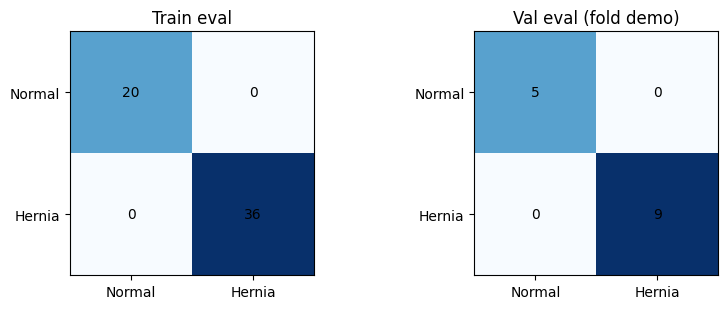

In [52]:
# Etapa 13) Resumen final: train vs validación
# Mini-resumen: contrastamos train vs validación para medir brecha de generalización y cerrar reporte.

# Priorizamos umbral global de CV (si existe) porque suele generalizar mejor.
# Si no hay CV, usamos el umbral del fold demo.
umbral_final = float(umbral_global) if 'umbral_global' in globals() else float(mejor['metricas']['umbral'])

print('Resumen del entrenamiento (fold demo):')
print(f"- épocas ejecutadas: {len(historial)}")
print(f"- mejor época: {int(mejor['metricas']['epoca'])}")
print(f"- train_loss(mejor): {mejor['metricas']['perdida_train']:.4f}")
print(f"- val_loss(mejor): {mejor['metricas']['perdida_val']:.4f}")
print(f"- umbral operativo final: {umbral_final:.4f}")
fuente_metricas_finales = 'ensemble_cv' if usar_ensemble_cv_activo() else 'modelo_demo'
print(f"- fuente métricas finales: {fuente_metricas_finales}")

# Evaluación adicional en train para cuantificar posible sobreajuste.
# Evaluamos train con transformaciones de validación para comparar en condiciones homogéneas.
ds_train_eval = ConjuntoHiatal(muestras, indices_entrenamiento, transf_validacion)
loader_train_eval = DataLoader(
    ds_train_eval,
    batch_size=TAM_BATCH,
    shuffle=False,
    num_workers=0,
    pin_memory=(DISPOSITIVO.type == 'cuda'),
)

# Generamos métricas finales; si hay ensemble CV lo usamos por mayor robustez.
usar_ensemble_final = usar_ensemble_cv_activo()

if usar_ensemble_final:
    y_train_eval, p_train_eval, _ = predecir_loader_ensemble(modelos_ensemble_cv, loader_train_eval, DISPOSITIVO)
    y_val_eval, p_val_eval, _ = predecir_loader_ensemble(modelos_ensemble_cv, loader_validacion, DISPOSITIVO)
else:
    y_train_eval, p_train_eval, _ = predecir_loader(modelo, loader_train_eval, DISPOSITIVO)
    y_val_eval, p_val_eval = y_real_demo, p_demo

metricas_train = calcular_metricas(y_train_eval, p_train_eval, umbral=umbral_final)
metricas_test = calcular_metricas(y_val_eval, p_val_eval, umbral=umbral_final)

# Tabla compacta comparativa entre train y validación.
resumen_df = pd.DataFrame([
    construir_fila_resumen_split('train_eval', y_train_eval, metricas_train),
    construir_fila_resumen_split('val_eval_fold_demo', y_val_eval, metricas_test),
])

print()
print('Métricas finales:')
print(resumen_df.round(4).to_string(index=False))

# Guardamos tabla final comparativa entre train y validación.
ruta_resumen_final = RUTA_SALIDA / 'resumen_final_train_test.csv'
resumen_df.to_csv(ruta_resumen_final, index=False)
mlflow_log_artifact(ruta_resumen_final)

mlflow_log_metricas(metricas_train, prefijo='final.train_eval')
mlflow_log_metricas(metricas_test, prefijo='final.val_eval')

# Derivamos clases binarias para construir matrices de confusión comparables.
pred_train_eval = (p_train_eval >= umbral_final).astype(int)
pred_val_eval = (p_val_eval >= umbral_final).astype(int)

cm_train = confusion_matrix(y_train_eval, pred_train_eval, labels=[0, 1])
cm_val = confusion_matrix(y_val_eval, pred_val_eval, labels=[0, 1])

# Visualizamos confusión en train vs validación lado a lado.
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.2))
dibujar_matriz_confusion(axes[0], cm_train, 'Train eval')
dibujar_matriz_confusion(axes[1], cm_val, 'Val eval (fold demo)')

plt.tight_layout()

# Persistimos matriz de confusión comparativa como evidencia visual.
ruta_cm_final = RUTA_SALIDA / 'confusion_train_val.png'
guardar_figura(fig, ruta_cm_final)

# Mostramos run_id y enlaces para abrir resultados rápidamente en MLflow UI.
if USAR_MLFLOW and (mlflow.active_run() is not None):
    run_id_mlflow = mlflow.active_run().info.run_id
    print(f"MLflow run_id: {run_id_mlflow}")
    print(f"MLflow URL experimento: {MLFLOW_UI_URL}")
    url_run_mlflow = mlflow_url_run(run_id=run_id_mlflow, experiment_id=MLFLOW_EXPERIMENTO_ID)
    if url_run_mlflow:
        print(f"MLflow URL run: {url_run_mlflow}")

plt.show()





<a id="etapa-15"></a>
## Etapa 15: Inferencia en 5 imágenes aleatorias (balanceadas)

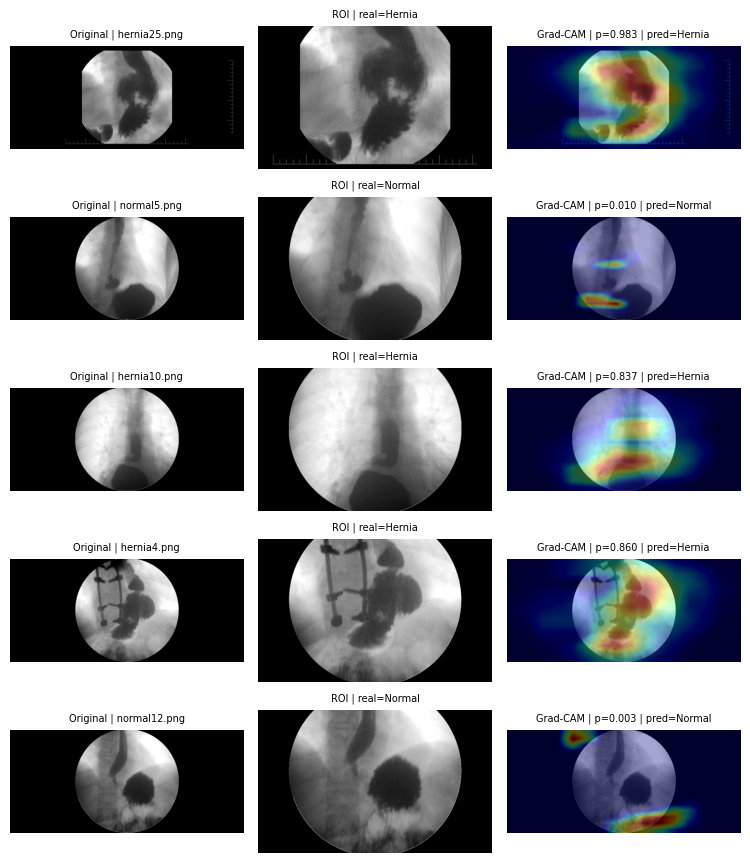

Resumen de inferencia aleatoria:
Fuente inferencia: ensemble_cv


,imagen,real,real_texto,prob_hernia,umbral,pred,pred_texto
0,hernia25.png,1,Hernia,0.9833,0.5918,1,Hernia
1,normal5.png,0,Normal,0.0097,0.5918,0,Normal
2,hernia10.png,1,Hernia,0.8372,0.5918,1,Hernia
3,hernia4.png,1,Hernia,0.8603,0.5918,1,Hernia
4,normal12.png,0,Normal,0.0031,0.5918,0,Normal


Estadísticas de la prueba aleatoria:


,n_imagenes,umbral,auc,accuracy,f1,sensibilidad,especificidad,tp,tn,fp,fn,real_hernia,real_normal,pred_hernia,pred_normal
0,5,0.5918,1.0,1.0,1.0,1.0,1.0,3,2,0,0,3,2,3,2


🏃 View run hiatal_20260213_145818 at: http://localhost:8050/#/experiments/1/runs/6c2da29299a244309d869dce760726b8
🧪 View experiment at: http://localhost:8050/#/experiments/1


In [53]:
# Etapa 15) Inferencia en 5 imágenes aleatorias (balanceadas)
# Mini-resumen: ejecutamos inferencia final en un lote balanceado para revisión cualitativa y cuantitativa.
#
# Esta es la etapa final de validación operativa en modo demostración.
# En vez de una sola imagen (muestra poco representativa), usamos varias
# para observar estabilidad de predicción en un mini-lote heterogéneo.
#
# Además aplicamos muestreo balanceado por clase para asegurar presencia de
# ejemplos normales y con hernia; esto evita conclusiones sesgadas en la revisión visual.
#
# También calculamos métricas del lote mostrado para complementar la inspección visual,
# incorporando lectura cuantitativa (accuracy, sensibilidad, especificidad, etc.).

N_IMAGENES_ALEATORIAS = 5
SEMILLA_MUESTRA_ALEATORIA = SEMILLA
umbral_inferencia = float(umbral_global) if 'umbral_global' in globals() else float(mejor['metricas']['umbral'])

# Semilla local para que la selección aleatoria sea reproducible.
rng = random.Random(SEMILLA_MUESTRA_ALEATORIA)

muestras_disponibles = [m for m in muestras if Path(m.ruta).exists()]
if len(muestras_disponibles) == 0:
    raise RuntimeError('No hay imágenes disponibles para inferencia aleatoria.')

# Buscamos que el panel final sea representativo y no anecdótico.
# Con muestreo aleatorio puro puede dominar una sola clase,
# especialmente con desbalance, distorsionando la interpretación humana.
# Por eso imponemos balance explícito entre normal y hernia.
muestras_normales = [m for m in muestras_disponibles if int(m.etiqueta) == 0]
muestras_hernia = [m for m in muestras_disponibles if int(m.etiqueta) == 1]

n_mostrar = min(N_IMAGENES_ALEATORIAS, len(muestras_disponibles))

if n_mostrar >= 2 and muestras_normales and muestras_hernia:
    n_normal = min(len(muestras_normales), n_mostrar // 2)
    n_hernia = min(len(muestras_hernia), n_mostrar // 2)

    seleccion_normales = rng.sample(muestras_normales, k=n_normal)
    seleccion_hernia = rng.sample(muestras_hernia, k=n_hernia)

    faltantes = n_mostrar - (n_normal + n_hernia)
    pool_extra = [m for m in muestras_disponibles if m not in seleccion_normales and m not in seleccion_hernia]
    seleccion_extra = rng.sample(pool_extra, k=faltantes) if faltantes > 0 else []

    muestras_aleatorias = seleccion_normales + seleccion_hernia + seleccion_extra
else:
    muestras_aleatorias = rng.sample(muestras_disponibles, k=n_mostrar)

# Mezclamos orden de visualización para evitar sesgo por clase agrupada.
rng.shuffle(muestras_aleatorias)

# Modo evaluación: desactiva dropout y estabiliza inferencia.
usar_ensemble_inferencia = usar_ensemble_cv_activo()
modelo_cam = modelos_ensemble_cv[0] if usar_ensemble_inferencia else modelo
if not usar_ensemble_inferencia:
    modelo.eval()
registros = []

# Si Grad-CAM está activo, añadimos una tercera columna con mapa de activación.
# Así comparamos en la misma fila: imagen original, ROI y evidencia interpretativa.
n_cols = 3 if MOSTRAR_GRADCAM else 2
figsize = (7.6, 1.75 * n_mostrar) if MOSTRAR_GRADCAM else (5.2, 1.7 * n_mostrar)
fig, axes = plt.subplots(n_mostrar, n_cols, figsize=figsize)
axes = asegurar_matriz_axes(axes, n_mostrar, n_cols)

# Inferencia muestra por muestra para combinar visualización y logging detallado.
for fila, muestra in enumerate(muestras_aleatorias):
    ruta = Path(muestra.ruta)
    y_real = int(muestra.etiqueta)
    real_texto = 'Hernia' if y_real == 1 else 'Normal'

    with Image.open(ruta) as imagen:
        rgb = imagen.convert('RGB')
        gris = rgb.convert('L')
        roi = RecorteRetrocardiaco()(rgb).convert('L') if USAR_ROI else gris

    # Preparamos tensor 4D (batch=1) con el mismo pipeline de validación.
    tensor = transf_validacion(rgb).unsqueeze(0).to(DISPOSITIVO)
    if usar_ensemble_inferencia:
        prob = predecir_tensor_ensemble(modelos_ensemble_cv, tensor)
    else:
        prob = predecir_tensor_modelo(modelo, tensor)

    pred = int(prob >= umbral_inferencia)
    pred_texto = 'Hernia' if pred == 1 else 'Normal'

    # Guardamos fila estructurada de resultados para análisis tabular posterior.
    registros.append({
        'imagen': ruta.name,
        'real': y_real,
        'real_texto': real_texto,
        'prob_hernia': prob,
        'umbral': umbral_inferencia,
        'pred': pred,
        'pred_texto': pred_texto,
    })

    axes[fila, 0].imshow(gris, cmap='gray')
    axes[fila, 0].set_title(f'Original | {ruta.name}', fontsize=7)
    axes[fila, 0].axis('off')

    axes[fila, 1].imshow(roi, cmap='gray')
    axes[fila, 1].set_title(f'ROI | real={real_texto}', fontsize=7)
    axes[fila, 1].axis('off')

    if MOSTRAR_GRADCAM:
        overlay, _ = superponer_gradcam(rgb, modelo_cam, transf_validacion)
        axes[fila, 2].imshow(overlay)
        axes[fila, 2].set_title(f'Grad-CAM | p={prob:.3f} | pred={pred_texto}', fontsize=7)
        axes[fila, 2].axis('off')

# Ajustamos layout para que todas las figuras sean legibles.
plt.tight_layout()
plt.show()

print('Resumen de inferencia aleatoria:')
print(f"Fuente inferencia: {'ensemble_cv' if usar_ensemble_inferencia else 'modelo_demo'}")
df_pruebas = pd.DataFrame(registros)
display(df_pruebas.round(4))

# Convertimos DataFrame a arrays para calcular métricas de forma vectorizada.
y_real_arr = df_pruebas['real'].to_numpy(dtype=int)
p_prob_arr = df_pruebas['prob_hernia'].to_numpy(dtype=float)

# Construimos resumen estadístico del mini-lote de inferencia.
estadisticas_prueba = pd.DataFrame([
    construir_estadisticas_lote(
        y_real=y_real_arr,
        p_prob=p_prob_arr,
        umbral=umbral_inferencia,
    )
])

print('Estadísticas de la prueba aleatoria:')
display(estadisticas_prueba.round(4))

# Registramos métricas del lote aleatorio para trazabilidad de demo/inferencia.
mlflow_log_metricas(estadisticas_prueba.iloc[0].to_dict(), prefijo='inferencia.random5')

# Cerramos MLflow aquí porque esta es la última etapa operativa del flujo.
# Mantener la corrida abierta puede mezclar métricas de ejecuciones posteriores.
mlflow_cerrar_run()


